In [55]:
#libraries for graph analysis
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from operator import itemgetter

#for general geo-analysis
import geopandas as gpd
import seaborn as sns

#for spatial interaction models
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
from math import sqrt

In [343]:
import sys
print(sys.version)

3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:39:48) 
[GCC 9.3.0]


In [2]:
tube = nx.read_graphml('london.graph') # dataset for network resilience
ldnOD = pd.read_csv('london_flows.csv') # dataset for scenario test

In [3]:
df = nx.to_pandas_edgelist(tube)

In [199]:
df.describe()

,length,flows
count,467.000000,467.000000
mean,1392.798069,21265.197002
std,846.848932,29151.195516
min,248.178706,0.000000
25%,839.916681,4698.000000
50%,1185.270599,11563.000000
75%,1725.616133,24180.500000
max,7266.373927,219499.000000


In [9]:
df.sort_values(['flows'], ascending=False).head(10)

,source,target,length,station_1_,flows,line_name,station_2_
38,Waterloo,Westminster,850.360026,Waterloo,219499,Jubilee,Westminster
42,Waterloo,Bank and Monument,2542.954444,Waterloo,216157,Waterloo & City,Bank and Monument
43,Westminster,Green Park,1423.780195,Westminster,189976,Jubilee,Green Park
103,Bank and Monument,Liverpool Street,841.502684,Bank and Monument,160401,Central,Liverpool Street
14,Stratford,Liverpool Street,6698.461270,Stratford,146148,TfL Rail,Liverpool Street
46,Green Park,Bond Street,1148.912313,Green Park,140801,Jubilee,Bond Street
232,Euston,King's Cross St. Pancras,863.369674,Euston,132144,Victoria,King's Cross St. Pancras
50,Green Park,Oxford Circus,1010.566475,Green Park,125407,Victoria,Oxford Circus
49,Green Park,Victoria,1209.599809,Green Park,121521,Victoria,Victoria
196,Highbury & Islington,King's Cross St. Pancras,2581.853010,Highbury & Islington,120037,Victoria,King's Cross St. Pancras


# 1. Resilience of London Underground Network
## 1-1) topological network

In [358]:
print(nx.info(tube))

Graph with 401 nodes and 467 edges


In [359]:
linenames = []
for a, b, c in tube.edges(data=True):
    if c['line_name'] in linenames:
        pass
    else:
        linenames.append(c['line_name'])
linenames

['Jubilee',
 'Metropolitan',
 'Central',
 'London Overground',
 'DLR',
 'TfL Rail',
 'Hammersmith & City',
 'Northern',
 'Bakerloo',
 'Waterloo & City',
 'Circle',
 'Piccadilly',
 'Victoria',
 'District']

In [360]:
#changing strings to numerical values
for node in tube.nodes():
    tube.nodes[node]['coords'] = eval(tube.nodes[node]['coords'])

#putting the name of nodes as an node attribute
names = {}
for i in tube.nodes():
    names[i] = i
nx.set_node_attributes(tube, names, 'station_name')

#labeling edges' origin and destination with edge attributes
nod_name1={(e1,e2):e1 for e1, e2 in tube.edges()}
nod_name2={(e1,e2):e2 for e1, e2 in tube.edges()}

nx.set_edge_attributes(tube,nod_name1,'station_1_')
nx.set_edge_attributes(tube,nod_name2,'station_2_')

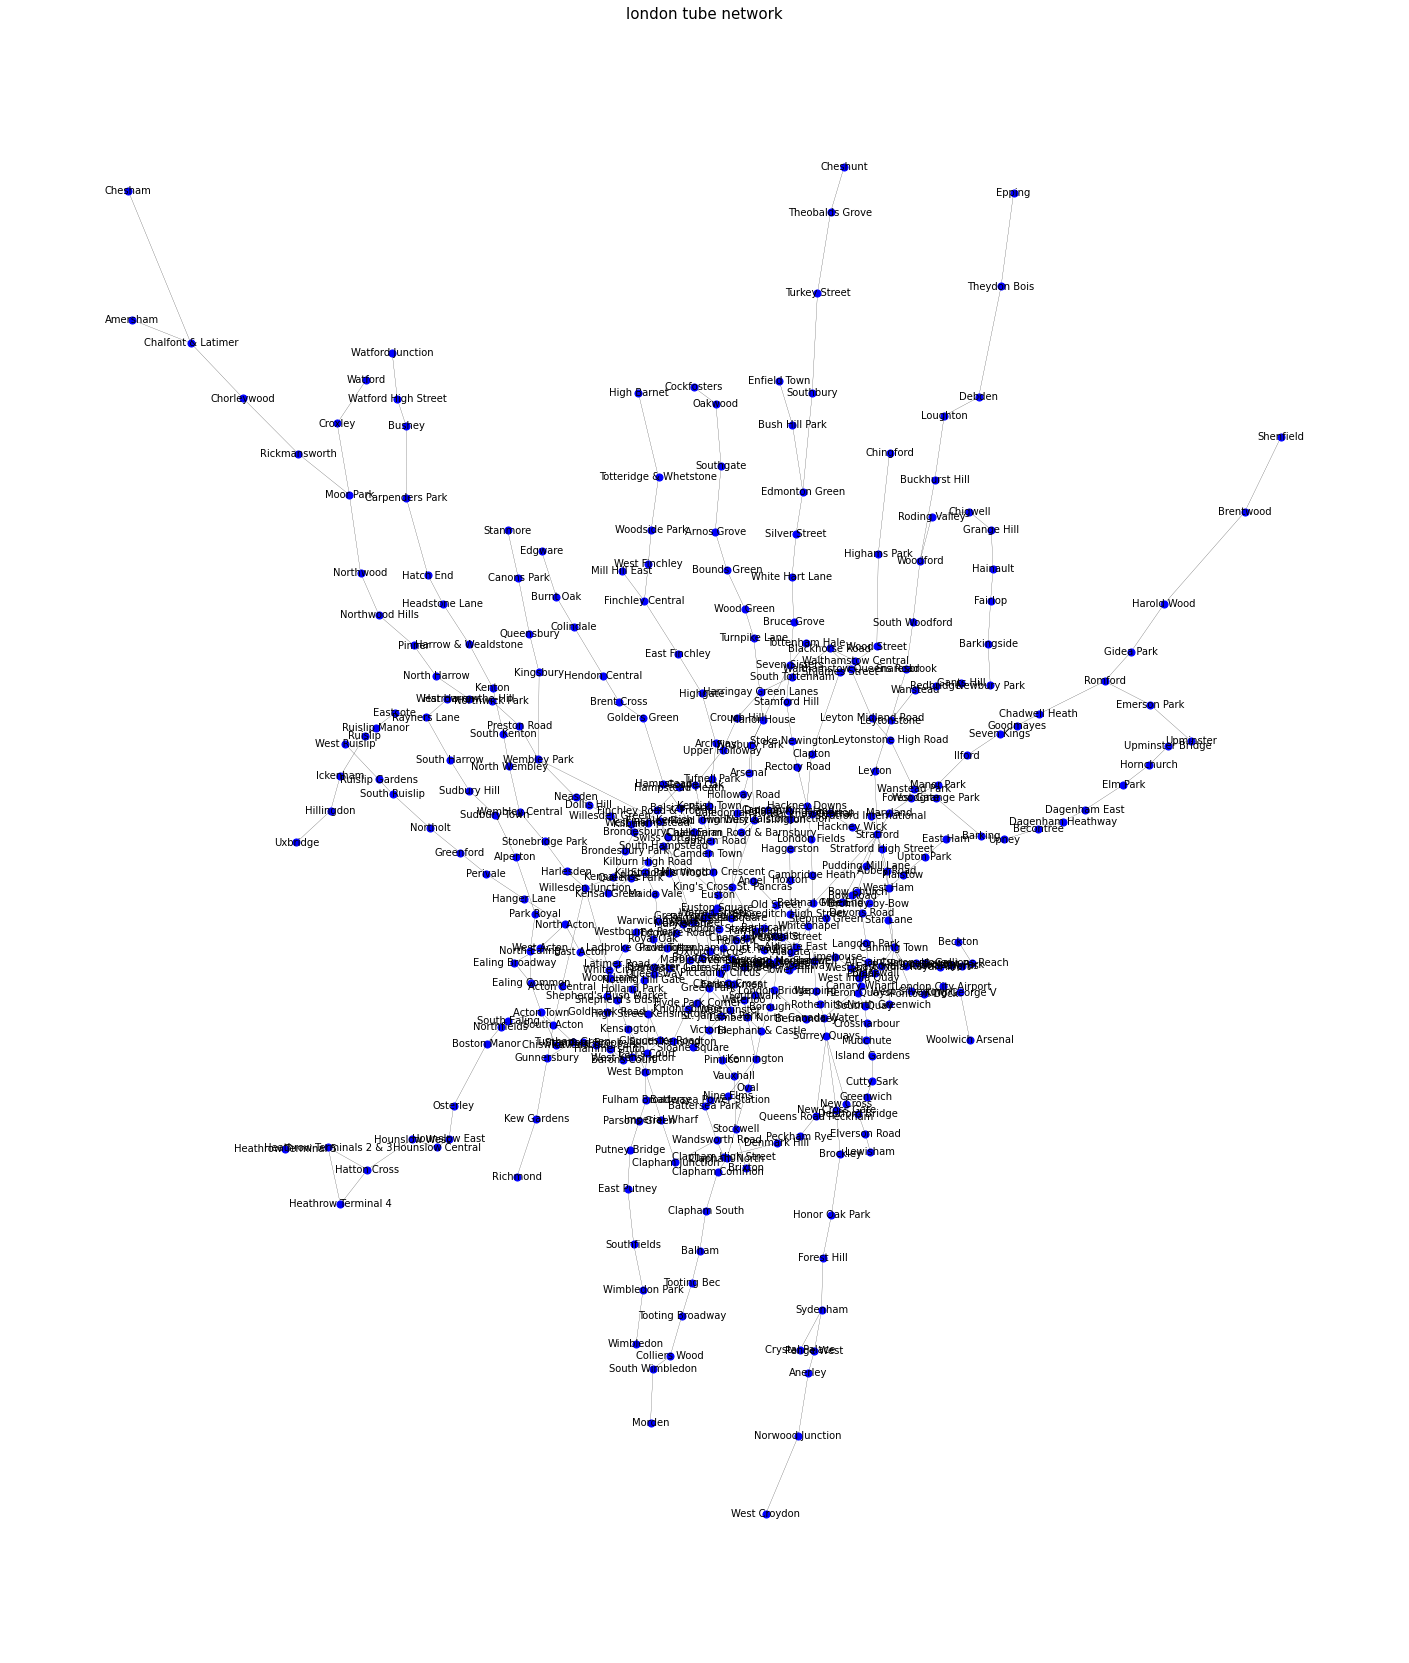

In [361]:
# checking the picture
fig, ax = plt.subplots(figsize=(25,30))

pos = nx.get_node_attributes(tube, 'coords')

nx.draw_networkx_nodes(tube, pos, node_size=50, node_color='b')
nx.draw_networkx_edges(tube, pos, arrows=False, width=0.2)
nx.draw_networkx_labels(tube, pos, names, font_size=10, font_color='black')

plt.title("london tube network", fontsize=15)
plt.axis('off')
plt.show()

In [10]:
print(nx.diameter(tube))

36


In [ ]:
#what does it mean exactly?
#nlen = {n:nx.single_source_dijkstra_path_length(tube, n, weight='length') for n in tube.nodes()}
#e = nx.eccentricity(tube,sp=nlen)
#d = nx.diameter(tube, e)
#d

### 1-1-1) Centrality Measure

In [288]:
list(tube.nodes(data=True))[0:5]

[('Wembley Park',
  {'coords': (519316.5590174915, 186389.32981656672),
   'station_name': 'Wembley Park',
   'degree': 0.01,
   'closeness_w': 4.8435910224477496e-05,
   'betweenness_len': 0.1130701754385965}),
 ('Kingsbury',
  {'coords': (519359.9688603217, 188721.22027255083),
   'station_name': 'Kingsbury',
   'degree': 0.005,
   'closeness_w': 4.2532256629882166e-05,
   'betweenness_len': 0.014924812030075188}),
 ('Queensbury',
  {'coords': (518811.3613368616, 189760.50737704366),
   'station_name': 'Queensbury',
   'degree': 0.005,
   'closeness_w': 4.041712532887401e-05,
   'betweenness_len': 0.009974937343358397}),
 ('Canons Park',
  {'coords': (518183.29968291725, 191257.26260848),
   'station_name': 'Canons Park',
   'degree': 0.005,
   'closeness_w': 3.78463965259625e-05,
   'betweenness_len': 0.005}),
 ('Stanmore',
  {'coords': (517580.4596464033, 192537.99948098673),
   'station_name': 'Stanmore',
   'degree': 0.0025,
   'closeness_w': 3.592119809981937e-05,
   'betweennes

#### 1-1-1-1) Degree Centrality

In [11]:
# top 10 by degree centrality

ldn_deg = nx.degree_centrality(tube)
nx.set_node_attributes(tube,dict(ldn_deg), 'degree')

df_deg = pd.DataFrame(index=tube.nodes())
df_deg['station_name'] = pd.Series(nx.get_node_attributes(tube, 'station_name'))
df_deg['degree'] = pd.Series(nx.get_node_attributes(tube, 'degree'))

df_deg_sorted = df_deg.sort_values(['degree'], ascending=False)
df_deg_sorted.head(10)

,station_name,degree
Stratford,Stratford,0.0225
Bank and Monument,Bank and Monument,0.0200
King's Cross St. Pancras,King's Cross St. Pancras,0.0175
Baker Street,Baker Street,0.0175
Earl's Court,Earl's Court,0.0150
Oxford Circus,Oxford Circus,0.0150
Liverpool Street,Liverpool Street,0.0150
Waterloo,Waterloo,0.0150
Green Park,Green Park,0.0150
Canning Town,Canning Town,0.0150


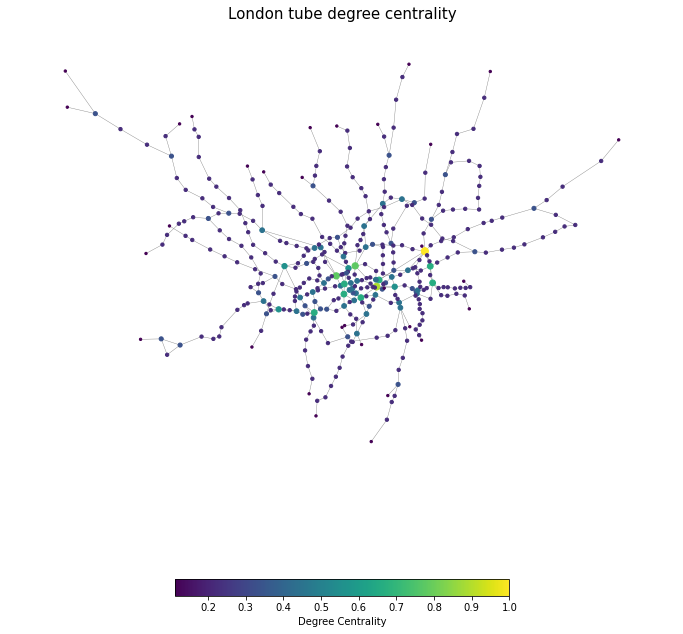

In [12]:
degree_values = [(i[1]['degree']) for i in tube.nodes(data=True)]

deg_color=[(i[1]['degree']/(max(degree_values))) for i in tube.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in tube.nodes(data=True)]

pos=pos

fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(tube, pos,edge_color='gray', width=0.4)
nod=nx.draw_networkx_nodes(tube,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube degree centrality",fontsize=15)
plt.show()

#### 1-1-1-2) Weighted Closeness Centrality by Distance

In [13]:
#distance closeness centrality

clos_w = nx.closeness_centrality(tube, distance='length')
nx.set_node_attributes(tube, clos_w,'closeness_w')

# To ataframe using the nodes as the index
df_wclos = pd.DataFrame(index=tube.nodes())
df_wclos['station_name'] = pd.Series(nx.get_node_attributes(tube, 'station_name'))
df_wclos['closeness_w'] = pd.Series(nx.get_node_attributes(tube, 'closeness_w'))

df_wclos_sorted = df_wclos.sort_values(["closeness_w"], ascending=False)
df_wclos_sorted.head(10)

,station_name,closeness_w
Holborn,Holborn,0.000079
King's Cross St. Pancras,King's Cross St. Pancras,0.000079
Tottenham Court Road,Tottenham Court Road,0.000079
Oxford Circus,Oxford Circus,0.000079
Leicester Square,Leicester Square,0.000078
Piccadilly Circus,Piccadilly Circus,0.000078
Charing Cross,Charing Cross,0.000078
Chancery Lane,Chancery Lane,0.000078
Covent Garden,Covent Garden,0.000078
Embankment,Embankment,0.000078


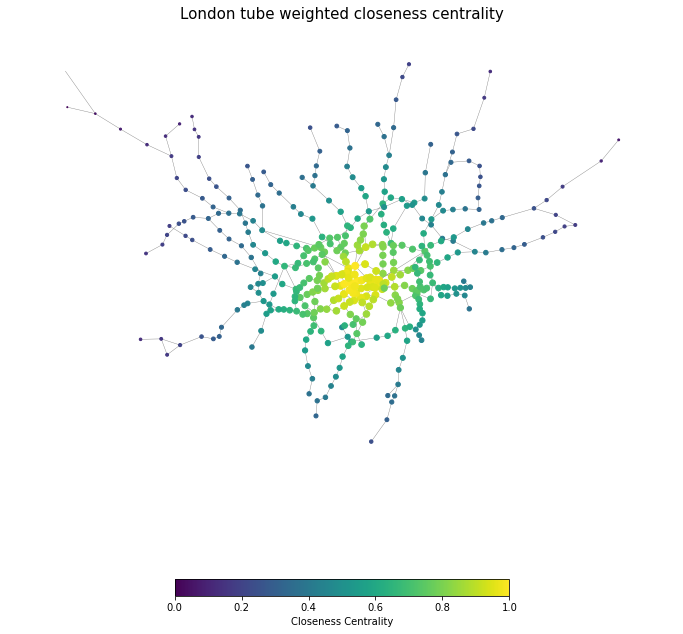

In [14]:
clos_w_val=[(i[1]['closeness_w']) for i in tube.nodes(data=True)]

closs_w_color=[(i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val)) for i in tube.nodes(data=True)]
closs_w_size=[((i[1]['closeness_w']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val))*50) for i in tube.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(tube, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(tube,
        pos = pos,
        node_color= closs_w_color,
        node_size= closs_w_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube weighted closeness centrality",fontsize=15)
plt.show()

#### 1-1-1-3) Betweenness Centrality by Distance

In [15]:
# number of a node's inclusion in the distance-weighted shortest path of the whole combinations of nodes

ldn_lbet = nx.betweenness_centrality(tube, weight='length',normalized=False)
nx.set_node_attributes(tube, ldn_lbet,'betweenness_len')

df_lbet = pd.DataFrame(index=tube.nodes())
df_lbet['station_name'] = pd.Series(nx.get_node_attributes(tube, 'station_name'))
df_lbet['betweenness_len'] = pd.Series(nx.get_node_attributes(tube, 'betweenness_len'))

df_lbet_sorted = df_lbet.sort_values(['betweenness_len'], ascending=False)
df_lbet_sorted.head(10)

,station_name,betweenness_len
Bank and Monument,Bank and Monument,17656.0
King's Cross St. Pancras,King's Cross St. Pancras,16693.0
Stratford,Stratford,14548.0
Oxford Circus,Oxford Circus,13561.0
Euston,Euston,13240.0
Baker Street,Baker Street,12150.0
Earl's Court,Earl's Court,11475.0
Shadwell,Shadwell,11128.0
Waterloo,Waterloo,10408.0
South Kensington,South Kensington,10335.0


In [16]:
#normalised

ldn_lbet = nx.betweenness_centrality(tube, weight='length',normalized=True)
nx.set_node_attributes(tube, ldn_lbet,'betweenness_len')

df_lbet = pd.DataFrame(index=tube.nodes())
df_lbet['station_name'] = pd.Series(nx.get_node_attributes(tube, 'station_name'))
df_lbet['betweenness_len'] = pd.Series(nx.get_node_attributes(tube, 'betweenness_len'))

df_lbet_sorted = df_lbet.sort_values(['betweenness_len'], ascending=False)
df_lbet_sorted.head(10)

,station_name,betweenness_len
Bank and Monument,Bank and Monument,0.221253
King's Cross St. Pancras,King's Cross St. Pancras,0.209185
Stratford,Stratford,0.182306
Oxford Circus,Oxford Circus,0.169937
Euston,Euston,0.165915
Baker Street,Baker Street,0.152256
Earl's Court,Earl's Court,0.143797
Shadwell,Shadwell,0.139449
Waterloo,Waterloo,0.130426
South Kensington,South Kensington,0.129511


### 1-1-2) Impact Measure

#### 1-1-2-1) Size of the Largest Component
It is expected to decrease when the central nodes are being terminated

In [18]:
nx.number_connected_components(tube)

1

In [37]:
G1 = tube.copy() # original tube graph
Subg = [G1.subgraph(c).copy() for c in nx.connected_components(G1)]
[len(subgraph.nodes) for subgraph in Subg]

[401]

In [38]:
components = nx.connected_components(G1)
largest_component = max(components, key=len)
Largest_subgraph = G1.subgraph(largest_component)
Largest_subgraph.number_of_nodes()

401

In [39]:
#defining function

def LargestCompSize(graph):
    comp = nx.connected_components(graph)
    largest_comp = max(comp, key=len)
    largest_subgraph = graph.subgraph(largest_comp)
    comp_num = nx.number_connected_components(graph)
    largest_node_num = largest_subgraph.number_of_nodes()
    return (largest_node_num, comp_num)

In [42]:
LargestCompSize(G1)

(401, 1)

#### 1-1-2-2) Average Length of Nodes Shortest Path to Every Node (Inverse)
It is expected to be down when more nodes are removed.

In [87]:
#defining function

def AvgShortest(graph):
    nlen = {n: nx.single_source_dijkstra_path_length(graph, n, weight='length') for n in graph.nodes()}
    avg_inversed_len = {}
    for i in nlen:
        inversed_short = 0 
        for j in nlen[i]:
            if nlen[i][j] == 0: ### when the node's disconnected and the shortest path of original nodes become null
                pass ## passing the 0's situation
            else:
                inversed_short += 1/nlen[i][j] ### to avoid 0's power to the shortest path 
        avg_inversed_len[i] = inversed_short /len(nlen)
    inversed_sum_of_node = 0 
    for i in avg_inversed_len:
        inversed_sum_of_node += avg_inversed_len[i]
    avg_node = inversed_sum_of_node / len(avg_inversed_len)
    return avg_node

In [290]:
print(AvgShortest(G1))
#when the nodes are cut, the distances become 0.

7.783958577576906e-05


### 1-1-3) Impact Measurement after Node Removal

#### 1-1-3-1) Non-sequential Removal

In [27]:
# measure the impact after each removal of top 10 nodes by each centrality type - no repeatition of centrality measurement

#ldn_deg: degree_centrality(tube)
#clos_w: closeness_centrality(tube, distance='length')
#ldn_lbet: betweenness_centrality(tube, weight='length',normalized=False)

centrality_set = [ldn_deg, clos_w, ldn_lbet] 

top10s = []
for i in range(len(centrality_set)):
    sorted_v = sorted(centrality_set[i].items(), key=itemgetter(1), reverse=True)
    top10 = [e for e, v in sorted_v[:10]]
    top10s.append(top10)

In [151]:
top10s[0]

['Stratford',
 'Bank and Monument',
 'Baker Street',
 "King's Cross St. Pancras",
 'West Ham',
 'Canning Town',
 'Waterloo',
 'Green Park',
 'Oxford Circus',
 'Liverpool Street']

In [140]:
Gdeg = tube.copy()
Gclos = tube.copy()
Gbet = tube.copy()

In [141]:
graphs = [Gdeg, Gclos, Gbet]

# storing impact measure changes of 3 centralities in the datasets
LCS = [[],[],[]]
AS = [[],[],[]]

for i in range(len(graphs)): # selecting centrality out of 3
    LCS[i].append(LargestCompSize(graphs[i])) #setting the original graph's largest component'size: 401
    AS[i].append(AvgShortest(graphs[i])) #original graph's shortest distance inversed
    for j in range(len(top10s[i])): # selecting j-th from top10
        graphs[i].remove_nodes_from([top10s[i][j]]) #removing j-th node from graph        
        LCS[i].append(LargestCompSize(graphs[i])) #calculating and storing LSC after j-th node's removal
        AS[i].append(AvgShortest(graphs[i]))

In [143]:
LCS_1 = [[], [], []] #extracting largest component size
for i in range(len(LCS)):
    for j in range(len(LCS[i])):
        LCS_1[i].append(LCS[i][j][0])

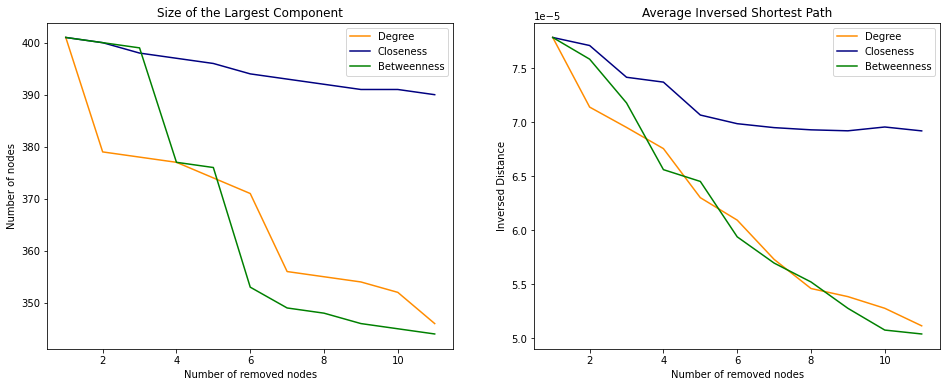

In [150]:
plt.subplots(1,2, figsize=(16, 6))

plt.subplot(121)
plt.title("Size of the Largest Component")
plt.xlabel("Number of removed nodes")
plt.ylabel("Number of nodes")
plt.plot(range(1,12), LCS_1[0], label='Degree', color="darkorange")
plt.plot(range(1,12), LCS_1[1], label='Closeness', color="navy")
plt.plot(range(1,12), LCS_1[2], label='Betweenness', color="green")
plt.legend(loc='best')

plt.subplot(122)
plt.title("Average Inversed Shortest Path")
plt.xlabel("Number of removed nodes")
plt.ylabel("Inversed Distance")
plt.plot(range(1,12), AS[0], label='Degree', color="darkorange")
plt.plot(range(1,12), AS[1], label='Closeness', color="navy")
plt.plot(range(1,12), AS[2], label='Betweenness', color="green")
plt.legend(loc='best')
plt.show()

#### 1-1-3-2) Sequential Removal

In [186]:
Gdeg1 = tube.copy()
Gclos1 = tube.copy()
Gbet1 = tube.copy()

In [187]:
graphs1 = [Gdeg1, Gclos1, Gbet1]

cendeg = nx.degree_centrality(Gdeg1)
cenclos = nx.closeness_centrality(Gclos1, distance='length')
cenbet = nx.betweenness_centrality(Gbet1, weight='length',normalized=False)

centrality_set1 = [cendeg, cenclos, cenbet]
tops = [[], [], []]

LCSseq = [[],[],[]]
ASseq = [[],[],[]]

for i in range(len(centrality_set1)):
    # Calculating and adding the impact measure
    LCSseq[i].append(LargestCompSize(graphs1[i])) #setting the original graph's largest component size
    ASseq[i].append(AvgShortest(graphs1[i])) #original graph's shortest distance inversed

num = 0

In [289]:
LCSseq[0]

[(401, 1),
 (379, 3),
 (378, 3),
 (377, 3),
 (374, 4),
 (360, 6),
 (359, 6),
 (358, 6),
 (357, 6),
 (355, 7),
 (341, 8)]

In [189]:
while num < 10:
    
    for i in range(len(centrality_set1)):
        
    # picking up the top centrality node
        sorted_v = sorted(centrality_set1[i].items(), key=itemgetter(1), reverse=True) # getting the sorted centrality list 
        top = sorted_v[0][0] # getting the top station
        tops[i].append(top) # storing the value on the list of top value
        
    # Removing node
        graphs1[i].remove_nodes_from([tops[i][num]])

    # Calculating and adding the impact measure        
        LCSseq[i].append(LargestCompSize(graphs1[i]))
        ASseq[i].append(AvgShortest(graphs1[i]))

        if i == 0:
            centrality_set1[i] = nx.degree_centrality(graphs1[i])
        elif i == 1:
            centrality_set1[i] = nx.closeness_centrality(graphs1[i], distance='length')
        elif i == 2:
            centrality_set1[i] = nx.betweenness_centrality(graphs1[i], weight='length', normalized=False)
    
    num += 1

In [191]:
LCSseq_1 = [[], [], []] #extracting largest component size
for i in range(len(LCSseq)):
    for j in range(len(LCSseq[i])):
        LCSseq_1[i].append(LCSseq[i][j][0])

In [194]:
df_top_seq = pd.DataFrame(data={"Degree": tops[0], "Closeness": tops[1], "Betweenness": tops[2]})
df_top_seq

,Degree,Closeness,Betweenness
0,Stratford,Holborn,Bank and Monument
1,Bank and Monument,King's Cross St. Pancras,King's Cross St. Pancras
2,Baker Street,Embankment,Canada Water
3,King's Cross St. Pancras,Waterloo,West Hampstead
4,Canning Town,London Bridge,Earl's Court
5,Green Park,West Hampstead,Oxford Circus
6,Earl's Court,Clapham Junction,Shepherd's Bush
7,Waterloo,Mile End,Baker Street
8,Oxford Circus,Stratford,Acton Town
9,Willesden Junction,Oxford Circus,Stratford


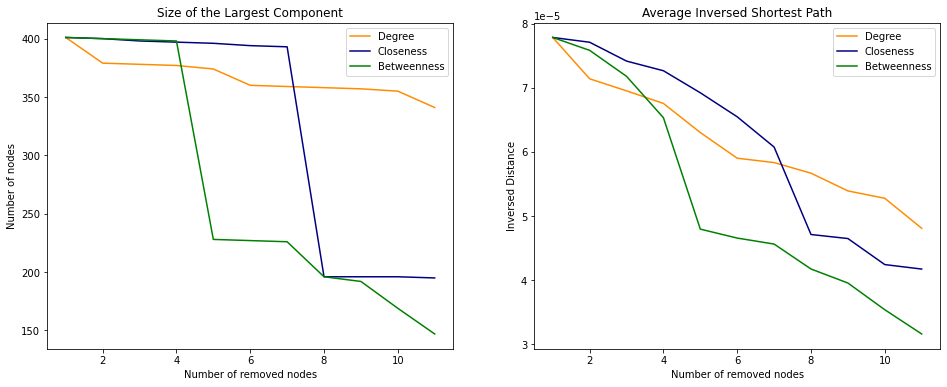

In [195]:
plt.subplots(1,2, figsize=(16, 6))

plt.subplot(121)
plt.title("Size of the Largest Component")
plt.xlabel("Number of removed nodes")
plt.ylabel("Number of nodes")
plt.plot(range(1,12), LCSseq_1[0], label='Degree', color="darkorange")
plt.plot(range(1,12), LCSseq_1[1], label='Closeness', color="navy")
plt.plot(range(1,12), LCSseq_1[2], label='Betweenness', color="green")
plt.legend(loc='best')

plt.subplot(122)
plt.title("Average Inversed Shortest Path")
plt.xlabel("Number of removed nodes")
plt.ylabel("Inversed Distance")
plt.plot(range(1,12), ASseq[0], label='Degree', color="darkorange")
plt.plot(range(1,12), ASseq[1], label='Closeness', color="navy")
plt.plot(range(1,12), ASseq[2], label='Betweenness', color="green")
plt.legend(loc='best')
plt.show()

## 1-2) weighted network

In [7]:
df = nx.to_pandas_edgelist(tube)

,source,target,length,station_1_,flows,line_name,station_2_
0,Wembley Park,Kingsbury,2916.771558,Wembley Park,12356,Jubilee,Kingsbury
1,Wembley Park,Neasden,2353.165938,Wembley Park,6744,Jubilee,Neasden
2,Wembley Park,Preston Road,1419.735166,Wembley Park,36601,Metropolitan,Preston Road
3,Wembley Park,Finchley Road,7266.373927,Wembley Park,55216,Metropolitan,Finchley Road
4,Kingsbury,Queensbury,1245.995234,Kingsbury,9419,Jubilee,Queensbury


In [8]:
df.describe()

,length,flows
count,467.000000,467.000000
mean,1392.798069,21265.197002
std,846.848932,29151.195516
min,248.178706,0.000000
25%,839.916681,4698.000000
50%,1185.270599,11563.000000
75%,1725.616133,24180.500000
max,7266.373927,219499.000000


In [9]:
df.sort_values(['flows'], ascending=False).head(10)

,source,target,length,station_1_,flows,line_name,station_2_
38,Waterloo,Westminster,850.360026,Waterloo,219499,Jubilee,Westminster
42,Waterloo,Bank and Monument,2542.954444,Waterloo,216157,Waterloo & City,Bank and Monument
43,Westminster,Green Park,1423.780195,Westminster,189976,Jubilee,Green Park
103,Bank and Monument,Liverpool Street,841.502684,Bank and Monument,160401,Central,Liverpool Street
14,Stratford,Liverpool Street,6698.461270,Stratford,146148,TfL Rail,Liverpool Street
46,Green Park,Bond Street,1148.912313,Green Park,140801,Jubilee,Bond Street
232,Euston,King's Cross St. Pancras,863.369674,Euston,132144,Victoria,King's Cross St. Pancras
50,Green Park,Oxford Circus,1010.566475,Green Park,125407,Victoria,Oxford Circus
49,Green Park,Victoria,1209.599809,Green Park,121521,Victoria,Victoria
196,Highbury & Islington,King's Cross St. Pancras,2581.853010,Highbury & Islington,120037,Victoria,King's Cross St. Pancras


In [200]:
df.dtypes

source         object
target         object
length        float64
station_1_     object
flows           int64
line_name      object
station_2_     object
dtype: object

### 1-2-1) Centrality for Weighted Network

#### 1-2-1-1) Weighted Betweenness Centrality

In [260]:
#weighted betweenness centrality 
#https://www.researchgate.net/publication/319108523_Analysis_of_Seoul_Metropolitan_Subway_Network_Characteristics_Using_Network_Centrality_Measures

df1 = df.drop(columns=['station_1_', 'station_2_', 'length', 'line_name'])
df2 = df1.groupby('source').flows.sum().reset_index()
df3 = df1.groupby('target').flows.sum().reset_index()

In [261]:
series_name = pd.Series(names)
df_name = pd.DataFrame(data = {'station_name': series_name})
df4 = pd.merge(df_name, df2, left_on='station_name', right_on='source', how='left')
df4 = df4.drop(columns=['source']).rename(columns={'flows': 'out'})
df5 = pd.merge(df4, df3, left_on='station_name', right_on='target', how='left')
df5 = df5.drop(columns=['target']).rename(columns={'flows': 'in'})

In [262]:
df5 = df5.fillna(0)
df5['total'] = df5['out'] + df5['in']
df5.sort_values(by=['total'], ascending=False)

,station_name,out,in,total
16,Green Park,438666.0,189976.0,628642.0
50,Bank and Monument,306182.0,312011.0,618193.0
14,Waterloo,523000.0,65394.0,588394.0
15,Westminster,256410.0,219499.0,475909.0
229,King's Cross St. Pancras,146535.0,303474.0,450009.0
...,...,...,...,...
264,Abbey Road,0.0,944.0,944.0
88,Cheshunt,0.0,287.0,287.0
179,Battersea Park,0.0,0.0,0.0
344,Battersea Power Station,0.0,0.0,0.0


In [264]:
outsum = df5['out'].sum()
insum = df5['in'].sum()
totalsum = df5['total'].sum()

In [275]:
df6 = pd.merge(df5, df_lbet, on='station_name', how='inner')

In [278]:
df6['weighted_bet'] = df6['betweenness_len'] * (df6['total']/totalsum)

,station_name,out,in,total,betweenness_len,weighted_bet
50,Bank and Monument,306182.0,312011.0,618193.0,0.221253,0.006886
229,King's Cross St. Pancras,146535.0,303474.0,450009.0,0.209185,0.004740
14,Waterloo,523000.0,65394.0,588394.0,0.130426,0.003864
5,Stratford,364561.0,0.0,364561.0,0.182306,0.003346
150,Euston,321210.0,33190.0,354400.0,0.165915,0.002960
...,...,...,...,...,...,...
344,Battersea Power Station,0.0,0.0,0.0,0.000000,0.000000
345,Nine Elms,0.0,0.0,0.0,0.005000,0.000000
30,West Ruislip,1277.0,0.0,1277.0,0.000000,0.000000
356,Shenfield,0.0,1181.0,1181.0,0.000000,0.000000


In [281]:
#1-1-1-3) Sorted by Betweenness Centrality
df_lbet_sorted.head(10)

,station_name,betweenness_len
Bank and Monument,Bank and Monument,0.221253
King's Cross St. Pancras,King's Cross St. Pancras,0.209185
Stratford,Stratford,0.182306
Oxford Circus,Oxford Circus,0.169937
Euston,Euston,0.165915
Baker Street,Baker Street,0.152256
Earl's Court,Earl's Court,0.143797
Shadwell,Shadwell,0.139449
Waterloo,Waterloo,0.130426
South Kensington,South Kensington,0.129511


##### ★weighted betwenness centrality top 10


In [279]:
# Sorted by weighted betweenness centrality
df6.sort_values(by='weighted_bet', ascending=False).head(10)

,station_name,out,in,total,betweenness_len,weighted_bet
50,Bank and Monument,306182.0,312011.0,618193.0,0.221253,0.006886
229,King's Cross St. Pancras,146535.0,303474.0,450009.0,0.209185,0.004740
14,Waterloo,523000.0,65394.0,588394.0,0.130426,0.003864
5,Stratford,364561.0,0.0,364561.0,0.182306,0.003346
150,Euston,321210.0,33190.0,354400.0,0.165915,0.002960
45,Oxford Circus,150704.0,148374.0,299078.0,0.169937,0.002559
18,Baker Street,204166.0,112517.0,316683.0,0.152256,0.002428
51,Liverpool Street,94346.0,306549.0,400895.0,0.106065,0.002141
15,Westminster,256410.0,219499.0,475909.0,0.089098,0.002135
16,Green Park,438666.0,189976.0,628642.0,0.063822,0.002020


In [280]:
##df6.sort_values(by='total', ascending=False).head(10)

,station_name,out,in,total,betweenness_len,weighted_bet
16,Green Park,438666.0,189976.0,628642.0,0.063822,0.002020
50,Bank and Monument,306182.0,312011.0,618193.0,0.221253,0.006886
14,Waterloo,523000.0,65394.0,588394.0,0.130426,0.003864
15,Westminster,256410.0,219499.0,475909.0,0.089098,0.002135
229,King's Cross St. Pancras,146535.0,303474.0,450009.0,0.209185,0.004740
51,Liverpool Street,94346.0,306549.0,400895.0,0.106065,0.002141
5,Stratford,364561.0,0.0,364561.0,0.182306,0.003346
150,Euston,321210.0,33190.0,354400.0,0.165915,0.002960
17,Bond Street,181054.0,140801.0,321855.0,0.063722,0.001033
18,Baker Street,204166.0,112517.0,316683.0,0.152256,0.002428


In [294]:
df6

,station_name,out,in,total,betweenness_len,weighted_bet
0,Wembley Park,110917.0,0.0,110917.0,0.113070,0.000631
1,Kingsbury,9419.0,12356.0,21775.0,0.014925,0.000016
2,Queensbury,6385.0,9419.0,15804.0,0.009975,0.000008
3,Canons Park,3624.0,6385.0,10009.0,0.005000,0.000003
4,Stanmore,0.0,3624.0,3624.0,0.000000,0.000000
...,...,...,...,...,...,...
396,Heathrow Terminal 5,0.0,1913.0,1913.0,0.000000,0.000000
397,Brixton,0.0,28465.0,28465.0,0.000000,0.000000
398,Vauxhall,61585.0,48147.0,109732.0,0.024862,0.000137
399,Pimlico,0.0,129620.0,129620.0,0.027707,0.000181


In [296]:
df6['total'][0]

110917.0

### 1-2-2) Impact Measure for Weighted Network

#### 1-2-2-1) Component Flow Analysis - Summation of non-largest components' flow (Flow Loss)

In [298]:
weights = {}
n = 0
for a in df6['station_name']:
    weights[a] = df6['total'][n]
    n += 1

In [299]:
Gw = tube.copy()
nx.set_node_attributes(Gw, weights, 'total_flows')

In [306]:
Gw1 = Gw.copy()

cenbet_test = nx.betweenness_centrality(Gw1, weight='length',normalized=False)
sorted_test = sorted(cenbet_test.items(), key=itemgetter(1), reverse=True)
top_test = [e for e, v in sorted_test[:10]]

Gw1.remove_nodes_from(top_test)

Subg_test = [Gw1.subgraph(c).copy() for c in nx.connected_components(Gw1)]
[len(subgraph.nodes) for subgraph in Subg_test]

[344, 20, 2, 1, 1, 22, 1]

In [308]:
subg_flows = []
for i in range(len(Subg_test)):
    flowdict = nx.get_node_attributes(Subg_test[i], 'total_flows')
    summ = 0
    for a in flowdict:
        summ += flowdict[a]
    subg_flows.append(summ)
subg_flows

[14782056.0, 506932.0, 196919.0, 4195.0, 3833.0, 890104.0, 3735.0]

In [309]:
totalsum

19861694.0

In [313]:
sum(subg_flows)

16387774.0

In [315]:
totalsum-sum(subg_flows) # 10 node's flows

3473920.0

In [321]:
sum(subg_flows[1:]) # non-largest components' flows

1605718.0

In [323]:
test_impact = (totalsum - subg_flows[0]) / totalsum * 100 

In [324]:
test_impact # 25% flows lost: lost component's flow + lost node's flow // summation of the squared values from each component's flow proportion will better explain of lost flow 

25.575049137299168

### 1-2-3) Alternative Impact Measure after Node Removal

#### 1-2-3-1) Removing one node with 1-1-1's best performing centrality (BC or DC)

In [331]:
Gw2 = Gw.copy()

cenbet_test = nx.betweenness_centrality(Gw2, weight='length',normalized=False)
sorted_test = sorted(cenbet_test.items(), key=itemgetter(1), reverse=True)
top_test = [e for e, v in sorted_test[:3]]
print(top_test)
Gw2.remove_nodes_from(top_test)

['Bank and Monument', "King's Cross St. Pancras", 'Stratford']


#### 1-2-3-2) Assessing Impact with 1-1-2-1(LargestComp), 1-1-2-2(Inversed Average Length) + 1-2-2-1(Flow Loss)

In [332]:
Subg_test = [Gw2.subgraph(c).copy() for c in nx.connected_components(Gw2)]
[len(subgraph.nodes) for subgraph in Subg_test]

[377, 20, 1]

In [333]:
subg_flows = []
for i in range(len(Subg_test)):
    flowdict = nx.get_node_attributes(Subg_test[i], 'total_flows')
    summ = 0
    for a in flowdict:
        summ += flowdict[a]
    subg_flows.append(summ)
subg_flows

[17918166.0, 506932.0, 3833.0]

In [334]:
test_impact = (totalsum - subg_flows[0]) / totalsum * 100 

In [335]:
test_impact

9.785308342782846

#### 1-2-3-3) Removing one(+a) node with 1-2-2's centrality (WBC)

In [340]:
Gw3 = Gw.copy()

In [341]:
stations = ["Bank and Monument", "King's Cross St. Pancras", "Waterloo"]

In [342]:
Gw3.remove_nodes_from(stations)
Subg_test = [Gw3.subgraph(c).copy() for c in nx.connected_components(Gw2)]
[len(subgraph.nodes) for subgraph in Subg_test]

[376, 20, 1]

In [343]:
subg_flows = []
for i in range(len(Subg_test)):
    flowdict = nx.get_node_attributes(Subg_test[i], 'total_flows')
    summ = 0
    for a in flowdict:
        summ += flowdict[a]
    subg_flows.append(summ)
subg_flows

[17329772.0, 506932.0, 3833.0]

#### 1-2-3-2) Assessing Impact with 1-1-2-1(LargestComp), 1-1-2-2(Inversed Average Length) + 1-2-2-1(Flow Loss)

In [344]:
test_impact = (totalsum - subg_flows[0]) / totalsum * 100 
test_impact

12.747764616653544

# 2. Spatial Interaction Models

## 2-3) model and beta calibration

### 2-3-1) Explanation of Spatial Interaction Model

### 2-3-2) Model Selection & Beta Calibration

In [4]:
cdata = ldnOD
cdata

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [179]:
cdatasub = ldnOD.pivot_table(values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasub

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [190]:
cdatasub_dest = ldnOD.pivot_table(values ="flows", columns="station_origin", index= "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasub_dest.sort_values(by=['All'], ascending=False).head(20)

station_origin,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_destination,,,,,,,,,,,,,,,,,,,,,
All,599.0,1224.0,3745.0,2886.0,3172.0,740.0,1624.0,1190.0,643.0,4199.0,...,7073.0,1664.0,6667.0,1088.0,1367.0,4868.0,530.0,3093.0,7892.0,1542391
Bank and Monument,0.0,NaN,66.0,5.0,95.0,93.0,7.0,14.0,NaN,591.0,...,126.0,38.0,149.0,0.0,NaN,317.0,NaN,240.0,1340.0,78549
Liverpool Street,NaN,NaN,55.0,67.0,47.0,NaN,4.0,57.0,NaN,19.0,...,10.0,9.0,86.0,8.0,632.0,424.0,NaN,27.0,NaN,61122
Canary Wharf,1.0,NaN,57.0,1.0,3.0,67.0,7.0,54.0,NaN,96.0,...,1.0,27.0,64.0,0.0,NaN,192.0,NaN,42.0,82.0,58772
Stratford,285.0,11.0,10.0,6.0,82.0,258.0,2.0,4.0,NaN,29.0,...,1.0,3.0,51.0,0.0,0.0,891.0,NaN,18.0,1642.0,55954
Oxford Circus,NaN,NaN,38.0,15.0,50.0,NaN,3.0,15.0,NaN,131.0,...,17.0,23.0,227.0,0.0,NaN,119.0,NaN,69.0,NaN,44368
King's Cross St. Pancras,NaN,NaN,64.0,351.0,111.0,NaN,15.0,42.0,NaN,95.0,...,10.0,14.0,339.0,67.0,NaN,49.0,NaN,92.0,NaN,33330
Victoria,NaN,NaN,53.0,5.0,31.0,NaN,19.0,27.0,NaN,189.0,...,40.0,12.0,293.0,0.0,NaN,68.0,NaN,90.0,NaN,33251
London Bridge,NaN,NaN,39.0,2.0,25.0,NaN,7.0,26.0,NaN,436.0,...,0.0,9.0,83.0,1.0,NaN,72.0,NaN,90.0,NaN,29930


In [ ]:
# flow map??

In [5]:
cdata = cdata.rename(columns={'station_origin': 'Orig', 'station_destination': 'Dest', 'population': 'O', 'jobs': 'D', 'distance': 'Dist'})
cdata

,Orig,Dest,flows,O,D,Dist
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


#### 2-3-2-1) Model Selection

#### 2-3-2-2) Beta Calibration

##### 2-3-2-2-1) Unconstrained Model

Text(0, 0.5, 'Flows')

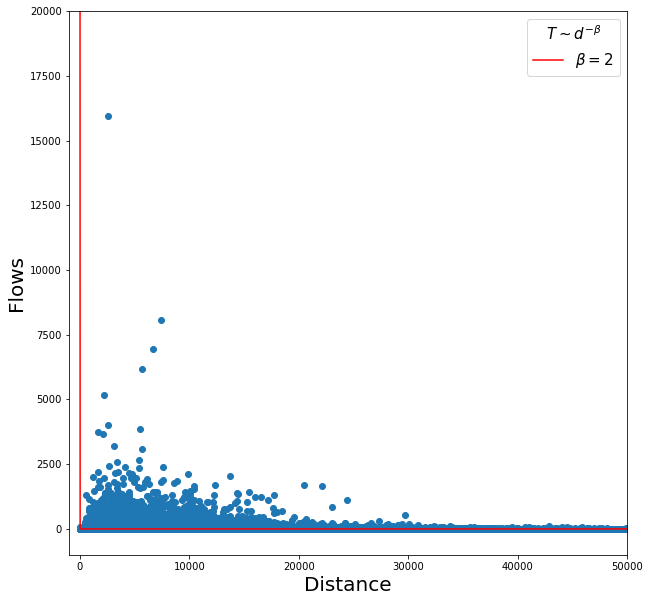

In [362]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x = cdata["Dist"], y=cdata["flows"])
line = np.arange(0.0002, 50_000, 0.1)
ax.plot(line, line**-2, color ="r", label = "$\\beta=2$")
ax.legend(title = "$T \\sim d^{-\\beta}$", fontsize = 15, title_fontsize=15)
ax.set_xlim([-1000,50000])
ax.set_ylim([-1000, 20000])
#set the labels
ax.set_xlabel("Distance", fontsize = 20)
ax.set_ylabel("Flows", fontsize = 20)

Text(0, 0.5, 'Total Flows')

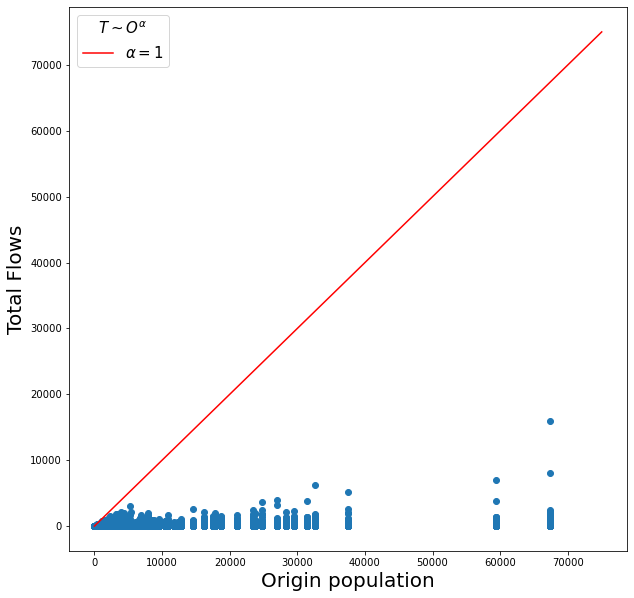

In [366]:
#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = cdata["O"], y=cdata["flows"])
#line plot
line = np.arange(0.0002, 75_000, 0.1)
ax.plot(line, line**1, color ="r", label = "$\\alpha=1$")
#add a legend
ax.legend( fontsize = 15, title = "$T \sim O^{\\alpha}$", title_fontsize=15)
#axis labels
ax.set_xlabel("Origin population", fontsize = 20)
ax.set_ylabel("Total Flows", fontsize = 20)

Text(0, 0.5, 'Flows')

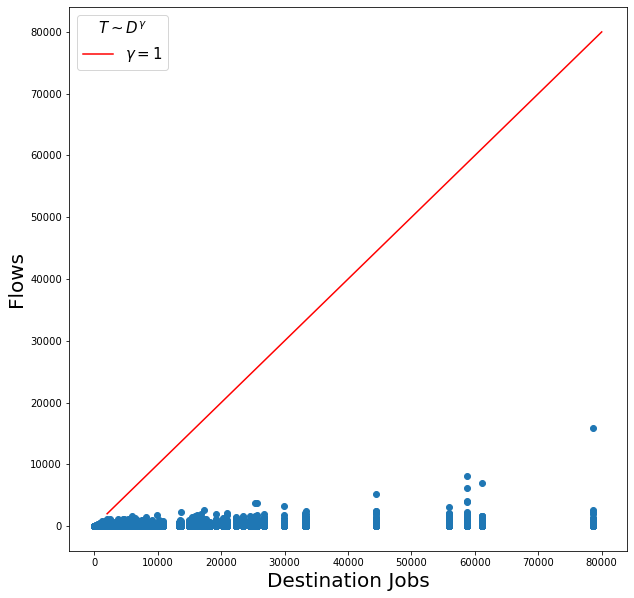

In [370]:
#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = cdata["D"], y=cdata["flows"])
#line plot
line = np.arange(2000, 80000, 0.1)
ax.plot(line, line**1, color ="r", label = "$\\gamma=1$")
#add a legend
ax.legend( fontsize = 15, title = "$T \sim D^{\\gamma}$", title_fontsize=15)
#axis labels
ax.set_xlabel("Destination Jobs", fontsize = 20)
ax.set_ylabel("Flows", fontsize = 20)

In [6]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [7]:
cdata = cdata.drop(cdata[cdata['Dist']==0].index) ## self-flow drop

In [9]:
alpha = 1
gamma = 1
beta = 2
k = 1
T2 = sum(cdata["flows"])

In [10]:
O_alpha = cdata["O"]**alpha
D_gamma = cdata["D"]**gamma
dist_beta = cdata["Dist"]**-beta
T1 = O_alpha*D_gamma*dist_beta
k = T2/sum(T1)

In [11]:
cdata["unconstrainedEst1"] = round(k*O_alpha*D_gamma*dist_beta, 0)
cdata.sort_values(by=['unconstrainedEst1'], ascending=False)

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1
32486,Liverpool Street,Moorgate,172,31473,24574,434.087449,55223.0
32326,Liverpool Street,Bank and Monument,812,31473,78549,841.502684,46971.0
32629,London Bridge,Bank and Monument,445,32597,78549,886.728371,43812.0
9419,Cannon Street,Bank and Monument,53,3874,78549,329.312716,37752.0
2712,Bank and Monument,Liverpool Street,1138,29494,61122,841.502684,34252.0
...,...,...,...,...,...,...,...
38231,Old Street,Amersham,0,5364,256,43752.330681,0.0
38230,Old Street,Alperton,0,5364,741,22110.571700,0.0
20056,Golders Green,Kennington,7,4792,1161,12610.425346,0.0
20058,Golders Green,Kew Gardens,1,4792,792,21882.186717,0.0


In [12]:
cdata["unconstrainedEst1"] = cdata["unconstrainedEst1"].astype(int)
#check that the sum of these estimates make sense
sum(cdata["unconstrainedEst1"])

1538987

In [403]:
T2 - sum(cdata["unconstrainedEst1"])

3296

In [405]:
CalcRSquared(cdata["flows"], cdata["unconstrainedEst1"]) ## only 3% of the variation of flows are being explained by the unconstrained...

0.03464371354941842

In [406]:
CalcRMSE(cdata["flows"], cdata["unconstrainedEst1"]) ## The closer to 0, the better the model...?

485.365

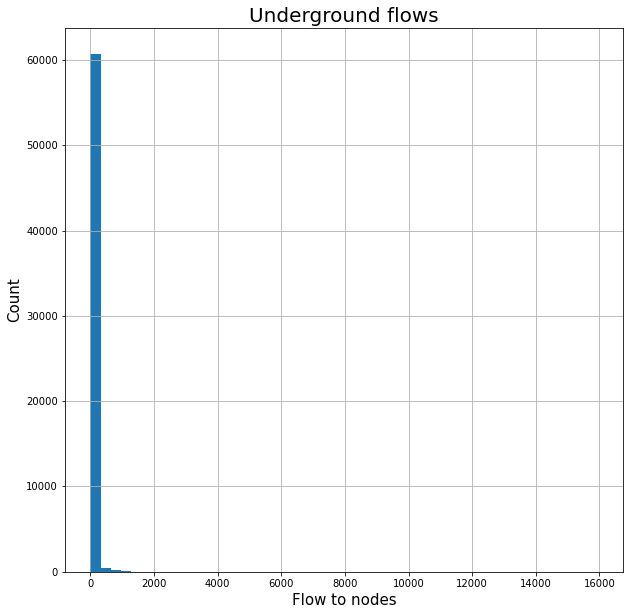

In [440]:
plt.subplots(figsize=(10,10))

plt.hist(cdata["flows"], histtype="stepfilled" , bins = 50)
plt.xlabel("Flow to nodes", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("Underground flows", fontsize = 20)
plt.grid(True)

In [13]:
x_var = ['O', 'D', 'Dist']
log_var = []
for x in x_var:
    cdata[f'log_{x}'] = np.log(cdata[x])
    log_var.append(f'log_{x}')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
formula = 'flows ~ log_O + log_D + log_Dist'
uncosim = smf.glm(formula = formula, 
                  data=cdata, 
                  family=sm.families.Poisson()).fit()
print(uncomsim.summary())

ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [15]:
cdata1 = cdata.drop(cdata[cdata['flows']==0].index) ## there were so many edges with 0 flow contaminating the dataset

##### 2-3-2-2-1-1) Unconstrained Model's Result

In [16]:
alpha = 1
gamma = 1
beta = 2
k = 1
T2 = sum(cdata1["flows"])

O_alpha = cdata1["O"]**alpha
D_gamma = cdata1["D"]**gamma
dist_beta = cdata1["Dist"]**-beta
T1 = O_alpha*D_gamma*dist_beta
k = T2/sum(T1)

cdata1["unconstrainedEst1"] = round(k*O_alpha*D_gamma*dist_beta, 0)

cdata1["unconstrainedEst1"] = cdata1["unconstrainedEst1"].astype(int)

print(T2 - sum(cdata1["unconstrainedEst1"]))

print(CalcRSquared(cdata1["flows"], cdata1["unconstrainedEst1"])) ## only 3% of the variation of flows are being explained by the unconstrained...
print(CalcRMSE(cdata1["flows"], cdata1["unconstrainedEst1"])) ## The closer to 0, the better the model...?

2067
0.03381700542510137
581.986


In [17]:
x_var = ['O', 'D', 'Dist']
log_var = []
for x in x_var:
    cdata1[f'log_{x}'] = np.log(cdata1[x])
    log_var.append(f'log_{x}')

formula = 'flows ~ log_O + log_D + log_Dist'
uncosim = smf.glm(formula = formula, 
                  data=cdata1, 
                  family=sm.families.Poisson()).fit()
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43941
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1675e+06
Date:                Mon, 02 May 2022   Deviance:                   2.1627e+06
Time:                        14:21:16   Pearson chi2:                 4.13e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.0646      0.014   -223.280      0.0

In [18]:
K = uncosim.params[0]
alpha = uncosim.params[1]
gamma = uncosim.params[2]
beta = -uncosim.params[3]

cdata1["unconstrainedEst2"] = np.exp(K 
                                       + alpha*cdata1["log_O"] 
                                       + gamma*cdata1["log_D"] 
                                       - beta*cdata1["log_Dist"])

predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()
cdata1['fitted'] = predictions_summary_frame['mean']

In [434]:
K

-3.0646358895454675

In [430]:
uncosim.mu

array([ 1.33185192,  2.88212504, 56.51864264, ...,  7.0022738 ,
       17.38163883, 15.21476603])

In [19]:
cdata1["unconstrainedEst2"] = round(cdata1["unconstrainedEst2"], 0)
#convert to integers
cdata1["unconstrainedEst2"] = cdata1["unconstrainedEst2"].astype(int)
#check that the sum of these estimates make sense
sum(cdata1["unconstrainedEst2"])

1542307

In [20]:
sum(cdata1['flows']) - sum(cdata1["unconstrainedEst2"])

-24

##### 2-3-2-2-1-2) Unconstrained Model's Result (applied by Poission)

In [21]:
print(CalcRSquared(cdata1["flows"], cdata1["unconstrainedEst2"])) ## only 3% of the variation of flows are being explained by the unconstrained...
print(CalcRMSE(cdata1["flows"], cdata1["unconstrainedEst2"])) ## The closer to 0, the better the model...?

0.3114155959170228
128.175


In [22]:
cdata1

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,unconstrainedEst2,fitted
1,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,1,1.331852
2,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,3,2.882125
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,57,56.518643
4,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,36,36.062256
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,3,3.120065
...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,2,8.973605,8.114325,9.503144,25,25.463983
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8,8.973605,8.610137,9.071245,47,46.695352
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,0,8.973605,5.991465,9.162905,7,7.002274
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,3,8.973605,6.794587,8.585832,17,17.381639


In [438]:
cdata1.sort_values(by=['flows'], ascending=False)

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,unconstrainedEst2,fitted
55949,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,11169,11.117985,11.271478,7.841082,2822,2821.507073
55974,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,978,11.117985,10.981421,8.913817,1214,1213.669905
50095,Stratford,Liverpool Street,6946,59311,61122,6698.461270,1103,10.990550,11.020627,8.809633,1215,1214.691411
32654,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,811,10.391976,10.981421,8.644567,859,858.928878
54825,Victoria,Oxford Circus,5181,37517,44368,2220.166284,4609,10.532549,10.700274,7.705337,1361,1360.735616
...,...,...,...,...,...,...,...,...,...,...,...,...
41100,Preston Road,Kennington,1,2358,1161,18399.933202,0,7.765569,7.057037,9.820102,4,4.314397
41104,Preston Road,Kingsbury,1,2358,1018,4336.506724,2,7.765569,6.925595,8.374824,9,9.309730
41109,Preston Road,Latimer Road,1,2358,1109,17416.439206,0,7.765569,7.011214,9.765170,4,4.316563
41115,Preston Road,Maida Vale,1,2358,949,15764.456495,0,7.765569,6.855409,9.665513,4,4.105096


##### 2-3-2-2-2) Production Constrained Model

In [ ]:
formula = 'flows ~ Orig + log_D + log_Dist-1'
prodSim = smf.glm(formula = formula, data=cdata1, family=sm.families.Poisson()).fit()
print(prodSim.summary())
#errored. too many origins

In [57]:
# classifying stations with zone
zone = pd.read_csv('London stations.csv')
zone

,Station,OS X,OS Y,Latitude,Longitude,Zone,Postcode
0,Abbey Road,539081,183352,51.531952,0.003723,3,E15 3NB
1,Abbey Wood,547297,179002,51.490784,0.120272,4,SE2 9RH
2,Acton Central,520613,180299,51.508757,-0.263430,2,W3 6BH
3,Acton Main Line,520296,181196,51.516886,-0.267690,3,W3 9EH
4,Acton Town,519457,179639,51.503071,-0.280303,3,W3 8HN
...,...,...,...,...,...,...,...
648,Woodside Park,525725,192564,51.617868,-0.185426,4,N12 8SE
649,Woolwich,543931,178994,51.491578,0.071819,4,NaN
650,Woolwich Arsenal,543754,178803,51.489907,0.069194,4,SE18 6HX
651,Woolwich Dockyard,542738,178908,51.491108,0.054612,3,SE18 5JY


In [118]:
zone = zone[['Station', 'Zone']]
cdata2 = pd.merge(cdata1, zone, left_on='Orig', right_on='Station', how='left')
cdata2.isna().sum()

Orig                    0
Dest                    0
flows                   0
O                       0
D                       0
Dist                    0
unconstrainedEst1       0
log_O                   0
log_D                   0
log_Dist                0
unconstrainedEst2       0
fitted                  0
Station              3045
Zone                 3075
dtype: int64

In [59]:
cdata2[cdata2['Zone'].isna()]['Orig'].unique()

array(['Bank and Monument', 'Caledonian Road & Barnsbury',
       'Chalfont & Latimer', 'Crossharbour', 'Cutty Sark', "Earl's Court",
       'Edgware Road', 'Elephant & Castle', 'Finchley Road & Frognal',
       'Hammersmith', 'Harrow & Wealdstone', 'Heathrow Terminals 2 & 3',
       'Highbury & Islington', 'Kensington', "King's Cross St. Pancras",
       "Queen's Park", "Regent's Park", "Shepherd's Bush",
       "Shepherd's Bush Market", "St. John's Wood", "St. Paul's",
       'Totteridge & Whetstone', 'Watford Junction'], dtype=object)

In [112]:
zone1 = ['Bank and Monument',"Earl's Court",'Edgware Road','Elephant & Castle', "Regent's Park", "King's Cross St. Pancras", "St. Paul's"]
zone2 = ['Caledonian Road & Barnsbury','Crossharbour','Cutty Sark','Finchley Road & Frognal','Hammersmith',"Queen's Park","Shepherd's Bush",'Highbury & Islington','Kensington',"Shepherd's Bush Market","St. John's Wood"]
zone4 = ['Totteridge & Whetstone']
zone5 = ['Harrow & Wealdstone']
zone6 = ['Heathrow Terminals 2 & 3']
zone7 = ['Watford Junction']
zone8 = ['Chalfont & Latimer']

#cdata2[cdata2['Orig'] == ('Bank and Monument'|"Earl's Court"|'Edgware Road'|'Elephant & Castle'|"Regent's Park"|"King's Cross St. Pancras"|"St. Paul's")]['Zone'] = 1
#cdata2[cdata2['Orig'] == ('Caledonian Road & Barnsbury'|'Crossharbour'| 'Cutty Sark'|'Finchley Road & Frognal'|'Hammersmith'|"Queen's Park"|"Shepherd's Bush"|'Highbury & Islington'|'Kensington'|"Shepherd's Bush Market"|"St. John's Wood")]['Orig'] = 2
#cdata2[cdata2['Orig'] == ('Chalfont & Latimer')]['Orig'] = 8
#cdata2[cdata2['Orig'] == ('Harrow & Wealdstone')]['Orig'] = 5
#cdata2[cdata2['Orig'] == ('Heathrow Terminals 2 & 3')]['Orig'] = 6
#cdata2[cdata2['Orig'] == ('Totteridge & Whetstone')]['Orig'] = 4
#cdata2[cdata2['Orig'] == ('Watford Junction')]['Orig'] = 7

In [119]:
cdata2.loc[cdata2['Orig'].isin(zone1), 'Zone'] = 1
cdata2.loc[cdata2['Orig'].isin(zone2), 'Zone'] = 2
cdata2.loc[cdata2['Orig'].isin(zone4), 'Zone'] = 4
cdata2.loc[cdata2['Orig'].isin(zone5), 'Zone'] = 5
cdata2.loc[cdata2['Orig'].isin(zone6), 'Zone'] = 6
cdata2.loc[cdata2['Orig'].isin(zone7), 'Zone'] = 7
cdata2.loc[cdata2['Orig'].isin(zone8), 'Zone'] = 8

In [120]:
cdata2 = cdata2.drop(columns=['Station']).rename(columns={'Zone': 'orig_zone'})
cdata2

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,unconstrainedEst2,fitted,orig_zone
0,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,1,1.331852,3
1,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,3,2.882125,3
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,57,56.518643,3
3,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,36,36.062256,3
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,3,3.120065,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,2,8.973605,8.114325,9.503144,25,25.463983,4
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8,8.973605,8.610137,9.071245,47,46.695352,4
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,0,8.973605,5.991465,9.162905,7,7.002274,4
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,3,8.973605,6.794587,8.585832,17,17.381639,4


In [125]:
cdata2['orig_zone'].unique()

[3, 2, 1, 4, 9, 5, 7, 8, 6]
Categories (9, int64): [1, 2, 3, 4, ..., 6, 7, 8, 9]

In [122]:
cdata2.isna().sum()

Orig                 0
Dest                 0
flows                0
O                    0
D                    0
Dist                 0
unconstrainedEst1    0
log_O                0
log_D                0
log_Dist             0
unconstrainedEst2    0
fitted               0
orig_zone            0
dtype: int64

In [123]:
cdata2.loc[cdata2['orig_zone'] == '2,3', 'orig_zone'] = 2
cdata2.loc[cdata2['orig_zone'] == '3,4', 'orig_zone'] = 3
cdata2.loc[cdata2['orig_zone'] == '5,6', 'orig_zone'] = 5
cdata2.loc[cdata2['orig_zone'] == '1,2', 'orig_zone'] = 1
cdata2.loc[cdata2['orig_zone'] == '6,7', 'orig_zone'] = 6

In [124]:
cdata2 = cdata2.astype({'orig_zone': 'int'})
cdata2 = cdata2.astype({'orig_zone': 'category'})
cdata2.dtypes

Orig                   object
Dest                   object
flows                   int64
O                       int64
D                       int64
Dist                  float64
unconstrainedEst1       int64
log_O                 float64
log_D                 float64
log_Dist              float64
unconstrainedEst2       int64
fitted                float64
orig_zone            category
dtype: object

In [126]:
formula1 = 'flows ~ orig_zone + log_D + log_Dist -1'
prodSim = smf.glm(formula = formula1, data=cdata2, family=sm.families.Poisson()).fit()

print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43934
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6026e+06
Date:                Mon, 02 May 2022   Deviance:                   3.0330e+06
Time:                        15:59:57   Pearson chi2:                 7.25e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
orig_zone[1]     4.5219      0.010    432.562   

In [140]:
O_i = pd.DataFrame(cdata2.groupby(["Orig"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
cdata3 = cdata2.merge(O_i, on = "Orig", how = "left")

D_j = pd.DataFrame(cdata2.groupby(["Dest"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
cdata3 = cdata3.merge(D_j, on = "Dest", how = "left")

In [141]:
cdata3

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,unconstrainedEst2,fitted,orig_zone,O_i,D_j
0,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,1,1.331852,3,599,442
1,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,3,2.882125,3,599,665
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,57,56.518643,3,599,58772
3,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,36,36.062256,3,599,15428
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,3,3.120065,3,599,1208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,2,8.973605,8.114325,9.503144,25,25.463983,4,7892,3342
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8,8.973605,8.610137,9.071245,47,46.695352,4,7892,5487
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,0,8.973605,5.991465,9.162905,7,7.002274,4,7892,400
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,3,8.973605,6.794587,8.585832,17,17.381639,4,7892,893


In [142]:
cdata3.dtypes

Orig                   object
Dest                   object
flows                   int64
O                       int64
D                       int64
Dist                  float64
unconstrainedEst1       int64
log_O                 float64
log_D                 float64
log_Dist              float64
unconstrainedEst2       int64
fitted                float64
orig_zone            category
O_i                     int64
D_j                     int64
dtype: object

In [143]:
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
coefs

,coef,alpha_i
0,orig_zone[1],4.521892
1,orig_zone[2],4.744223
2,orig_zone[3],5.194484
3,orig_zone[4],4.851541
4,orig_zone[5],4.805009
5,orig_zone[6],4.782129
6,orig_zone[7],4.951057
7,orig_zone[8],4.561495
8,orig_zone[9],4.609653
9,log_D,0.671281


In [144]:
to_repl = ["(orig_zone)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")

coefs

/tmp/ipykernel_1246/785335231.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,coef,alpha_i
0,1,4.521892
1,2,4.744223
2,3,5.194484
3,4,4.851541
4,5,4.805009
5,6,4.782129
6,7,4.951057
7,8,4.561495
8,9,4.609653
9,log_D,0.671281


In [146]:
coefs['coef'] = coefs['coef'].astype('object')
cdata3['orig_zone'] = cdata3['orig_zone'].astype('object')
print(coefs.dtypes)
print(cdata3.dtypes)

coef        object
alpha_i    float64
dtype: object
Orig                  object
Dest                  object
flows                  int64
O                      int64
D                      int64
Dist                 float64
unconstrainedEst1      int64
log_O                float64
log_D                float64
log_Dist             float64
unconstrainedEst2      int64
fitted               float64
orig_zone             object
O_i                    int64
D_j                    int64
dtype: object


In [147]:
cdata3 = pd.merge(cdata3, coefs, left_on="orig_zone", right_on="coef", how = "left")
cdata3.drop(columns = ["coef"], inplace = True)

cdata3.head()

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,unconstrainedEst2,fitted,orig_zone,O_i,D_j,alpha_i
0,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,1,1.331852,3,599,442,5.194484
1,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,3,2.882125,3,599,665,5.194484
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,57,56.518643,3,599,58772,5.194484
3,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,36,36.062256,3,599,15428,5.194484
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,3,3.120065,3,599,1208,5.194484


In [148]:
alpha_i = prodSim.params[0:9]
gamma = prodSim.params[9]
beta = -prodSim.params[10]

In [283]:
prodSim.params

orig_zone[1]    4.521892
orig_zone[2]    4.744223
orig_zone[3]    5.194484
orig_zone[4]    4.851541
orig_zone[5]    4.805009
orig_zone[6]    4.782129
orig_zone[7]    4.951057
orig_zone[8]    4.561495
orig_zone[9]    4.609653
log_D           0.671281
log_Dist       -0.779700
dtype: float64

In [149]:
alpha_i

orig_zone[1]    4.521892
orig_zone[2]    4.744223
orig_zone[3]    5.194484
orig_zone[4]    4.851541
orig_zone[5]    4.805009
orig_zone[6]    4.782129
orig_zone[7]    4.951057
orig_zone[8]    4.561495
orig_zone[9]    4.609653
dtype: float64

In [152]:
cdata3["prodsimest1"] = np.exp(cdata3["alpha_i"] + gamma*cdata3["log_D"] 
                                 - beta*cdata3["log_Dist"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
cdata3.head(10)

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,unconstrainedEst2,fitted,orig_zone,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,1,1.331852,3,599,442,5.194484,9.280816
1,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,3,2.882125,3,599,665,5.194484,23.008024
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,57,56.518643,3,599,58772,5.194484,369.395774
3,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,36,36.062256,3,599,15428,5.194484,286.389704
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,3,3.120065,3,599,1208,5.194484,21.996917
5,Abbey Road,Cutty Sark,2,599,1748,8503.898909,0,6.395262,7.466228,9.048280,4,3.506225,3,599,1748,5.194484,23.370517
6,Abbey Road,Cyprus,7,599,850,6532.099618,0,6.395262,6.745236,8.784484,2,2.470543,3,599,850,5.194484,17.693014
7,Abbey Road,Devons Road,1,599,611,3958.324171,0,6.395262,6.415097,8.283576,3,2.639878,3,599,611,5.194484,20.949427
8,Abbey Road,East India,2,599,1522,3384.141666,1,6.395262,7.327781,8.126856,6,5.509198,3,599,1522,5.194484,43.683606
9,Abbey Road,Island Gardens,2,599,691,7706.296370,0,6.395262,6.538140,8.949793,2,1.935092,3,599,691,5.194484,13.534722


In [153]:
cdata3["prodsimest1"] = round(cdata3["prodsimest1"], 0)
cdatasub3 = cdata3.pivot_table(values ="prodsimest1", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasub3

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,3040.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,781.0
Acton Town,NaN,NaN,NaN,37.0,37.0,NaN,20.0,NaN,NaN,40.0,...,34.0,8.0,12.0,27.0,NaN,NaN,NaN,NaN,NaN,6765.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,...,NaN,NaN,10.0,8.0,NaN,NaN,NaN,NaN,NaN,6829.0
Aldgate East,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,63.0,...,15.0,NaN,NaN,8.0,NaN,4.0,NaN,4.0,NaN,7287.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,28.0,30.0,NaN,NaN,NaN,NaN,26.0,...,13.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3593.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,404.0
Woodside Park,NaN,NaN,8.0,26.0,26.0,NaN,NaN,NaN,NaN,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3584.0


##### 2-3-2-2-2-1) Production Constrained Model Result

In [154]:
print(CalcRSquared(cdata3["flows"], cdata3["prodsimest1"]))
print(CalcRMSE(cdata3["flows"], cdata3["prodsimest1"]))

0.0873557524858858
147.724


##### 2-3-2-2-3) Attraction Constrained Model

In [237]:
cdata4

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,...,prodsimest1,D_s1,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,Station,Zone
0,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,...,9.0,442,9.0,69181.554039,2.170551e-07,9.0,2.410811e-07,10.0,Beckton,3
1,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,...,23.0,665,23.0,48291.048724,2.170551e-07,6.0,2.410811e-07,7.0,Blackwall,2
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,...,369.0,29386,232.0,774944.376511,2.170551e-07,160.0,2.410811e-07,112.0,Canary Wharf,2
3,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,...,286.0,15428,286.0,264264.911037,2.170551e-07,34.0,2.410811e-07,38.0,Canning Town,3
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,...,22.0,1208,22.0,112573.657072,2.170551e-07,15.0,2.410811e-07,16.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,2,8.973605,8.114325,9.503144,...,18.0,3342,18.0,383305.237781,7.287476e-08,220.0,7.720421e-08,234.0,Tower Gateway,1
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8,8.973605,8.610137,9.071245,...,35.0,5487,35.0,381804.830048,7.287476e-08,220.0,7.720421e-08,233.0,West Ham,3
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,0,8.973605,5.991465,9.162905,...,6.0,400,6.0,70704.745972,7.287476e-08,41.0,7.720421e-08,43.0,West India Quay,2
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,3,8.973605,6.794587,8.585832,...,15.0,893,15.0,77299.659952,7.287476e-08,44.0,7.720421e-08,47.0,West Silvertown,3


In [233]:
cdata4 = pd.merge(cdata3, zone, left_on='Dest', right_on='Station', how='left')
cdata4.isna().sum()

Orig                    0
Dest                    0
flows                   0
O                       0
D                       0
Dist                    0
unconstrainedEst1       0
log_O                   0
log_D                   0
log_Dist                0
unconstrainedEst2       0
fitted                  0
orig_zone               0
O_i                     0
D_j                     0
alpha_i                 0
prodsimest1             0
D_s1                    0
prodsimest2             0
Ai1                     0
A_i                     0
prodsimest3             0
A_i2                    0
prodsimest4             0
Station              3533
Zone                 3567
dtype: int64

In [239]:
cdata4[cdata4['Zone'].isna()]['Dest'].unique()

array(['Crossharbour', 'Cutty Sark', 'Caledonian Road & Barnsbury',
       'Finchley Road & Frognal', 'Harrow & Wealdstone',
       'Highbury & Islington', 'Watford Junction', 'Bank and Monument',
       "Earl's Court", 'Edgware Road', 'Elephant & Castle', 'Hammersmith',
       'Heathrow Terminals 2 & 3', "King's Cross St. Pancras",
       "Regent's Park", "Shepherd's Bush Market", "St. John's Wood",
       "St. Paul's", 'Totteridge & Whetstone', 'Chalfont & Latimer',
       "Queen's Park", "Shepherd's Bush", 'Kensington'], dtype=object)

In [240]:

zone1 = ['Bank and Monument',"Earl's Court",'Edgware Road','Elephant & Castle', "Regent's Park", "King's Cross St. Pancras", "St. Paul's"]
zone2 = ['Caledonian Road & Barnsbury','Crossharbour','Cutty Sark','Finchley Road & Frognal','Hammersmith',"Queen's Park","Shepherd's Bush",'Highbury & Islington','Kensington',"Shepherd's Bush Market","St. John's Wood"]
zone4 = ['Totteridge & Whetstone']
zone5 = ['Harrow & Wealdstone']
zone6 = ['Heathrow Terminals 2 & 3']
zone7 = ['Watford Junction']
zone8 = ['Chalfont & Latimer']


cdata4.loc[cdata4['Dest'].isin(zone1), 'Zone'] = 1
cdata4.loc[cdata4['Dest'].isin(zone2), 'Zone'] = 2
cdata4.loc[cdata4['Dest'].isin(zone4), 'Zone'] = 4
cdata4.loc[cdata4['Dest'].isin(zone5), 'Zone'] = 5
cdata4.loc[cdata4['Dest'].isin(zone6), 'Zone'] = 6
cdata4.loc[cdata4['Dest'].isin(zone7), 'Zone'] = 7
cdata4.loc[cdata4['Dest'].isin(zone8), 'Zone'] = 8

cdata4 = cdata4.drop(columns=['Station']).rename(columns={'Zone': 'dest_zone'})
cdata4

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,...,alpha_i,prodsimest1,D_s1,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,dest_zone
0,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,...,5.194484,9.0,442,9.0,69181.554039,2.170551e-07,9.0,2.410811e-07,10.0,3
1,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,...,5.194484,23.0,665,23.0,48291.048724,2.170551e-07,6.0,2.410811e-07,7.0,2
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,...,5.194484,369.0,29386,232.0,774944.376511,2.170551e-07,160.0,2.410811e-07,112.0,2
3,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,...,5.194484,286.0,15428,286.0,264264.911037,2.170551e-07,34.0,2.410811e-07,38.0,3
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,...,5.194484,22.0,1208,22.0,112573.657072,2.170551e-07,15.0,2.410811e-07,16.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,2,8.973605,8.114325,9.503144,...,4.851541,18.0,3342,18.0,383305.237781,7.287476e-08,220.0,7.720421e-08,234.0,1
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8,8.973605,8.610137,9.071245,...,4.851541,35.0,5487,35.0,381804.830048,7.287476e-08,220.0,7.720421e-08,233.0,3
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,0,8.973605,5.991465,9.162905,...,4.851541,6.0,400,6.0,70704.745972,7.287476e-08,41.0,7.720421e-08,43.0,2
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,3,8.973605,6.794587,8.585832,...,4.851541,15.0,893,15.0,77299.659952,7.287476e-08,44.0,7.720421e-08,47.0,3


In [241]:
cdata4['dest_zone'].unique()

array(['3', '2', 2, '2,3', '4', '1', 5, '5', '1,2', '3,4', '8', 7, 1, '7',
       '5,6', '6', 6, 4, 8, '6,7', '9'], dtype=object)

In [245]:

cdata4.loc[cdata4['dest_zone'] == '2,3', 'dest_zone'] = 2
cdata4.loc[cdata4['dest_zone'] == '3,4', 'dest_zone'] = 3
cdata4.loc[cdata4['dest_zone'] == '5,6', 'dest_zone'] = 5
cdata4.loc[cdata4['dest_zone'] == '1,2', 'dest_zone'] = 1
cdata4.loc[cdata4['dest_zone'] == '6,7', 'dest_zone'] = 6

cdata4 = cdata4.astype({'dest_zone': 'int'})
cdata4 = cdata4.astype({'dest_zone': 'category'})
cdata4.dtypes

Orig                   object
Dest                   object
flows                   int64
O                       int64
D                       int64
Dist                  float64
unconstrainedEst1       int64
log_O                 float64
log_D                 float64
log_Dist              float64
unconstrainedEst2       int64
fitted                float64
orig_zone            category
O_i                     int64
D_j                     int64
alpha_i               float64
prodsimest1           float64
D_s1                    int64
prodsimest2           float64
Ai1                   float64
A_i                   float64
prodsimest3           float64
A_i2                  float64
prodsimest4           float64
dest_zone            category
dtype: object

In [246]:
cdata4['dest_zone'].unique()

[3, 2, 4, 1, 5, 8, 7, 6, 9]
Categories (9, int64): [1, 2, 3, 4, ..., 6, 7, 8, 9]

In [248]:
attr_form = 'flows ~ dest_zone + log_O + log_Dist-1'
attrSim = smf.glm(formula = attr_form, data=cdata4, family=sm.families.Poisson()).fit()
print(attrSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43934
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6624e+06
Date:                Mon, 02 May 2022   Deviance:                   3.1525e+06
Time:                        18:27:08   Pearson chi2:                 9.44e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dest_zone[1]     4.4053      0.011    414.372   

In [250]:
cdata4

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,...,alpha_i,prodsimest1,D_s1,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,dest_zone
0,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,...,5.194484,9.0,442,9.0,69181.554039,2.170551e-07,9.0,2.410811e-07,10.0,3
1,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,...,5.194484,23.0,665,23.0,48291.048724,2.170551e-07,6.0,2.410811e-07,7.0,2
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,...,5.194484,369.0,29386,232.0,774944.376511,2.170551e-07,160.0,2.410811e-07,112.0,2
3,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,...,5.194484,286.0,15428,286.0,264264.911037,2.170551e-07,34.0,2.410811e-07,38.0,3
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,...,5.194484,22.0,1208,22.0,112573.657072,2.170551e-07,15.0,2.410811e-07,16.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,2,8.973605,8.114325,9.503144,...,4.851541,18.0,3342,18.0,383305.237781,7.287476e-08,220.0,7.720421e-08,234.0,1
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8,8.973605,8.610137,9.071245,...,4.851541,35.0,5487,35.0,381804.830048,7.287476e-08,220.0,7.720421e-08,233.0,3
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,0,8.973605,5.991465,9.162905,...,4.851541,6.0,400,6.0,70704.745972,7.287476e-08,41.0,7.720421e-08,43.0,2
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,3,8.973605,6.794587,8.585832,...,4.851541,15.0,893,15.0,77299.659952,7.287476e-08,44.0,7.720421e-08,47.0,3


In [251]:
predictions = attrSim.get_prediction(cdata4[["dest_zone", "log_O", "log_Dist"]])
predictions_summary_frame = predictions.summary_frame()
cdata4["attrsimFitted"] = round(predictions_summary_frame["mean"],0)

cdata4

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,...,prodsimest1,D_s1,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,dest_zone,attrsimFitted
0,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,...,9.0,442,9.0,69181.554039,2.170551e-07,9.0,2.410811e-07,10.0,3,7.0
1,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,...,23.0,665,23.0,48291.048724,2.170551e-07,6.0,2.410811e-07,7.0,2,12.0
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,...,369.0,29386,232.0,774944.376511,2.170551e-07,160.0,2.410811e-07,112.0,2,10.0
3,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,...,286.0,15428,286.0,264264.911037,2.170551e-07,34.0,2.410811e-07,38.0,3,18.0
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,...,22.0,1208,22.0,112573.657072,2.170551e-07,15.0,2.410811e-07,16.0,2,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,2,8.973605,8.114325,9.503144,...,18.0,3342,18.0,383305.237781,7.287476e-08,220.0,7.720421e-08,234.0,1,57.0
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8,8.973605,8.610137,9.071245,...,35.0,5487,35.0,381804.830048,7.287476e-08,220.0,7.720421e-08,233.0,3,39.0
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,0,8.973605,5.991465,9.162905,...,6.0,400,6.0,70704.745972,7.287476e-08,41.0,7.720421e-08,43.0,2,35.0
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,3,8.973605,6.794587,8.585832,...,15.0,893,15.0,77299.659952,7.287476e-08,44.0,7.720421e-08,47.0,3,54.0


In [253]:
cdatasub6 = cdata4.pivot_table(values ="attrsimFitted", index="Orig", columns = "Dest",
                                    aggfunc=np.sum, margins=True)
cdatasub6

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,371.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,432.0
Acton Town,NaN,NaN,NaN,30.0,30.0,NaN,20.0,NaN,NaN,32.0,...,16.0,18.0,13.0,28.0,NaN,NaN,NaN,NaN,NaN,4415.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0,...,NaN,NaN,16.0,15.0,NaN,NaN,NaN,NaN,NaN,4629.0
Aldgate East,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,72.0,...,13.0,NaN,NaN,16.0,NaN,9.0,NaN,8.0,NaN,5783.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,12.0,38.0,40.0,NaN,NaN,NaN,NaN,35.0,...,12.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,3853.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.0
Woodside Park,NaN,NaN,10.0,26.0,26.0,NaN,NaN,NaN,NaN,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2687.0


##### 2-3-2-2-3-1) Result

In [255]:
print(CalcRSquared(cdata4["flows"], cdata4["attrsimFitted"]))
print(CalcRMSE(cdata4["flows"], cdata4["attrsimFitted"]))

0.11409479748806721
145.3


##### 2-3-2-2-4) Doubly Constrained Model

In [256]:
dbl_form = 'flows ~ dest_zone + orig_zone + log_Dist-1'
doubSim = smf.glm(formula = dbl_form, data=cdata4, family=sm.families.Poisson()).fit()
print(doubSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43927
Model Family:                 Poisson   Df Model:                           17
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.0608e+06
Date:                Mon, 02 May 2022   Deviance:                   3.9493e+06
Time:                        18:36:23   Pearson chi2:                 1.78e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
dest_zone[1]      10.5646      0.008   1304.

In [259]:
#get the estimates
cdata4["doubsimfitted"] = np.round(doubSim.mu)

#cdatasub7 = cdata4.pivot_table(values ="doubsimfitted", index="Orig", columns = "Dest",
#                                    aggfunc=np.sum, margins=True)
#cdatasubmat7

In [260]:
print(CalcRSquared(cdata4["flows"],cdata4["doubsimfitted"]))
print(CalcRMSE(cdata4["flows"],cdata4["doubsimfitted"]))

0.029503229309457785
152.208


##### ※**2-3-2-2-5)** Unconstrained Model with Zone Distance

In [266]:
cdata4['dest_zone'] = cdata4['dest_zone'].astype('int')
cdata4['orig_zone'] = cdata4['orig_zone'].astype('int')
cdata4['zone_dist'] = abs(cdata4['orig_zone'] - cdata4['dest_zone'])

In [ ]:
#cdata4['dest_zone'] = cdata4['dest_zone'].astype('object')
#cdata4['orig_zone'] = cdata4['orig_zone'].astype('object')

In [270]:
cdata4

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,...,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,dest_zone,attrsimFitted,doubsimfitted,zone_dist
0,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,...,9.0,69181.554039,2.170551e-07,9.0,2.410811e-07,10.0,3,7.0,39.0,0
1,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,...,23.0,48291.048724,2.170551e-07,6.0,2.410811e-07,7.0,2,12.0,69.0,1
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,...,232.0,774944.376511,2.170551e-07,160.0,2.410811e-07,112.0,2,10.0,55.0,1
3,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,...,286.0,264264.911037,2.170551e-07,34.0,2.410811e-07,38.0,3,18.0,104.0,0
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,...,22.0,112573.657072,2.170551e-07,15.0,2.410811e-07,16.0,2,8.0,45.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,2,8.973605,8.114325,9.503144,...,18.0,383305.237781,7.287476e-08,220.0,7.720421e-08,234.0,1,57.0,41.0,3
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8,8.973605,8.610137,9.071245,...,35.0,381804.830048,7.287476e-08,220.0,7.720421e-08,233.0,3,39.0,27.0,1
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,0,8.973605,5.991465,9.162905,...,6.0,70704.745972,7.287476e-08,41.0,7.720421e-08,43.0,2,35.0,25.0,2
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,3,8.973605,6.794587,8.585832,...,15.0,77299.659952,7.287476e-08,44.0,7.720421e-08,47.0,3,54.0,39.0,1


In [275]:
new_form = 'flows ~ zone_dist + log_O + log_D-1' # exponential cost function of zone distance (zone_dist)
newSim = smf.glm(formula = new_form, data=cdata4, family=sm.families.Poisson()).fit()
print(newSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43941
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3125e+06
Date:                Mon, 02 May 2022   Deviance:                   2.4528e+06
Time:                        18:55:34   Pearson chi2:                 5.45e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.2475      0.010   -960.599      0.0

In [276]:
cdata4["newsimfitted"] = np.round(newSim.mu)
print(CalcRSquared(cdata4["flows"],cdata4["newsimfitted"]))
print(CalcRMSE(cdata4["flows"],cdata4["newsimfitted"]))

0.3254829191468411
128.277


## 2-4) Scenario Test

In [170]:
sum(ldnOD['flows']) - sum(cdata['flows'])

108

### 2-4-1) Scenario A - 50% of Canary Whalf's Job have disappeared

In [160]:
cdata[(cdata['Orig'] == 'Canary Wharf')]

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist
8805,Canary Wharf,Abbey Road,2,14632,345,5086.514220,3,9.590966,5.843544,8.534348
8806,Canary Wharf,Acton Town,7,14632,2202,20398.165882,1,9.590966,7.697121,9.923200
8807,Canary Wharf,Aldgate,0,14632,7782,6564.419680,36,9.590966,8.959569,8.789419
8808,Canary Wharf,Aldgate East,3,14632,7932,5127.998899,59,9.590966,8.978660,8.542471
8809,Canary Wharf,All Saints,27,14632,444,1340.088733,49,9.590966,6.095825,7.200491
...,...,...,...,...,...,...,...,...,...,...
9105,Canary Wharf,Wood Green,4,14632,2146,16849.246595,1,9.590966,7.671361,9.732061
9106,Canary Wharf,Wood Lane,0,14632,1578,17092.091760,1,9.590966,7.363914,9.746371
9107,Canary Wharf,Woodford,3,14632,706,13963.787075,1,9.590966,6.559615,9.544223
9108,Canary Wharf,Woodside Park,0,14632,745,22356.567178,0,9.590966,6.613384,10.014875


In [281]:
cdata[(cdata['Dest'] == 'Canary Wharf')]

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,18,6.395262,10.981421,8.534348
126,Acton Town,Canary Wharf,57,3745,58772,20398.165882,7,8.228177,10.981421,9.923200
348,Aldgate,Canary Wharf,1,2886,58772,6564.419680,53,7.967627,10.981421,8.789419
595,Aldgate East,Canary Wharf,3,3172,58772,5127.998899,95,8.062118,10.981421,8.542471
817,All Saints,Canary Wharf,67,740,58772,1340.088733,326,6.606650,10.981421,7.200491
...,...,...,...,...,...,...,...,...,...,...
60595,Wood Green,Canary Wharf,64,6667,58772,16849.246595,19,8.804925,10.981421,9.732061
60838,Wood Lane,Canary Wharf,0,1088,58772,17092.091760,3,6.992096,10.981421,9.746371
61062,Woodford,Canary Wharf,192,4868,58772,13963.787075,20,8.490438,10.981421,9.544223
61294,Woodside Park,Canary Wharf,42,3093,58772,22356.567178,5,8.036897,10.981421,10.014875


#### 2-4-1-1) Changing CW's job

In [173]:
def new_job(row):
    if row['Dest'] == 'Canary Wharf':
        val = 29386
    else:
        val = row['D']
    return val

cdata3['D_s1'] = cdata3.apply(new_job, axis=1)

In [175]:
cdata3.head()

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,unconstrainedEst2,fitted,orig_zone,O_i,D_j,alpha_i,prodsimest1,D_s1
0,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,1,1.331852,3,599,442,5.194484,9.0,442
1,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,3,2.882125,3,599,665,5.194484,23.0,665
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,57,56.518643,3,599,58772,5.194484,369.0,29386
3,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,36,36.062256,3,599,15428,5.194484,286.0,15428
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,3,3.120065,3,599,1208,5.194484,22.0,1208


#### 2-4-1-2) Calculating new values from change

In [318]:
alpha = newSim.params[2]
gamma = newSim.params[3]
beta = -newSim.params[1]
dummy = newSim.params[0]

cdata4['newsimest'] = np.exp(alpha*cdata4['log_O'] + gamma*cdata4['log_D'] - beta*cdata4['zone_dist'] + dummy)
cdata4["newsimest"] = round(cdata4["newsimest"],0)

In [319]:
cdata4

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,...,prodsimest4,dest_zone,attrsimFitted,doubsimfitted,zone_dist,newsimfitted,newsimest,newsimest1,Dist_s2,newsimest2
0,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,...,10.0,3,7.0,39.0,0,1.0,1.0,1.0,0,1.0
1,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,...,7.0,2,12.0,69.0,1,1.0,1.0,1.0,2,1.0
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,...,112.0,2,10.0,55.0,1,45.0,45.0,26.0,2,37.0
3,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,...,38.0,3,18.0,104.0,0,19.0,19.0,19.0,0,19.0
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,...,16.0,2,8.0,45.0,1,2.0,2.0,2.0,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,2,8.973605,8.114325,9.503144,...,234.0,1,57.0,41.0,3,23.0,23.0,23.0,6,13.0
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8,8.973605,8.610137,9.071245,...,233.0,3,39.0,27.0,1,49.0,49.0,49.0,2,41.0
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,0,8.973605,5.991465,9.162905,...,43.0,2,35.0,25.0,2,5.0,5.0,5.0,4,4.0
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,3,8.973605,6.794587,8.585832,...,47.0,3,54.0,39.0,1,12.0,12.0,12.0,2,10.0


In [320]:
table = cdata4.pivot_table(values ="newsimest", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
table

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,191.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,374.0
Acton Town,NaN,NaN,NaN,31.0,31.0,NaN,6.0,NaN,NaN,31.0,...,38.0,6.0,17.0,11.0,NaN,NaN,NaN,NaN,NaN,4874.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,...,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN,NaN,4062.0
Aldgate East,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,41.0,...,23.0,NaN,NaN,10.0,NaN,4.0,NaN,4.0,NaN,5015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,17.0,31.0,31.0,NaN,NaN,NaN,NaN,32.0,...,38.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,5106.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0
Woodside Park,NaN,NaN,12.0,22.0,22.0,NaN,NaN,NaN,NaN,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3422.0


In [286]:
cdata4['newsimest1'] = np.exp(alpha*cdata4['log_O'] + gamma*np.log(cdata4['D_s1']) - beta*cdata4['zone_dist'] + dummy)
cdata4["newsimest1"] = round(cdata4["newsimest1"],0)

table1 = cdata4.pivot_table(values ="newsimest1", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)

In [ ]:
### does it need refitting of model?

#new_form = 'flows ~ zone_dist + log_O + log_D-1' # exponential cost function of zone distance (zone_dist)
#newSim = smf.glm(formula = new_form, data=cdata4, family=sm.families.Poisson()).fit()
#print(newSim.summary())

#cdata4["newsimfitted"] = np.round(newSim.mu)
#print(CalcRSquared(cdata4["flows"],cdata4["newsimfitted"]))
#print(CalcRMSE(cdata4["flows"],cdata4["newsimfitted"]))

#alpha = newSim.params[2]
#gamma = newSim.params[3]
#beta = -newSim.params[1]
#dummy = newSim.params[0]

#cdata4['newsimest'] = np.exp(alpha*cdata4['log_O'] + gamma*cdata4['log_D'] - beta*cdata4['zone_dist'] + dummy)

In [287]:
table1

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,172.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,374.0
Acton Town,NaN,NaN,NaN,31.0,31.0,NaN,6.0,NaN,NaN,31.0,...,38.0,6.0,17.0,11.0,NaN,NaN,NaN,NaN,NaN,4802.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,...,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN,NaN,4003.0
Aldgate East,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,41.0,...,23.0,NaN,NaN,10.0,NaN,4.0,NaN,4.0,NaN,4951.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,17.0,31.0,31.0,NaN,NaN,NaN,NaN,32.0,...,38.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,5033.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0
Woodside Park,NaN,NaN,12.0,22.0,22.0,NaN,NaN,NaN,NaN,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3370.0


In [177]:
#cdata3["prodsimest2"] = np.exp(cdata3["alpha_i"]+gamma*np.log(cdata3["D_s1"]) - beta*cdata3["log_Dist"])

#cdata3["prodsimest2"] = round(cdata3["prodsimest2"],0)

#cdatasub4 = cdata3.pivot_table(values ="prodsimest2", index="Orig", columns = "Dest",
#                            aggfunc=np.sum, margins=True)
#cdatasub4

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,2903.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,781.0
Acton Town,NaN,NaN,NaN,37.0,37.0,NaN,20.0,NaN,NaN,40.0,...,34.0,8.0,12.0,27.0,NaN,NaN,NaN,NaN,NaN,6719.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,...,NaN,NaN,10.0,8.0,NaN,NaN,NaN,NaN,NaN,6771.0
Aldgate East,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,63.0,...,15.0,NaN,NaN,8.0,NaN,4.0,NaN,4.0,NaN,7218.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,28.0,30.0,NaN,NaN,NaN,NaN,26.0,...,13.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3549.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,404.0
Woodside Park,NaN,NaN,8.0,26.0,26.0,NaN,NaN,NaN,NaN,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3553.0


In [288]:
table1_dest = cdata4.pivot_table(values ="newsimest1", index="Dest", columns = "Orig",
                            aggfunc=np.sum, margins=True)

table1_dest.sort_values(by=['All'], ascending=False).head(15)

Orig,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Dest,,,,,,,,,,,,,,,,,,,,,
All,172.0,374.0,4802.0,4003.0,4951.0,274.0,1742.0,528.0,101.0,6470.0,...,6005.0,2048.0,8091.0,905.0,142.0,5033.0,45.0,3370.0,1336.0,1519919.0
Bank and Monument,NaN,NaN,181.0,218.0,234.0,65.0,80.0,25.0,NaN,288.0,...,292.0,99.0,279.0,NaN,NaN,183.0,NaN,130.0,262.0,63293.0
Stratford,52.0,73.0,204.0,115.0,123.0,50.0,90.0,28.0,NaN,152.0,...,328.0,111.0,314.0,NaN,NaN,205.0,NaN,146.0,294.0,51630.0
Liverpool Street,NaN,NaN,150.0,180.0,193.0,NaN,66.0,20.0,NaN,238.0,...,240.0,82.0,230.0,72.0,58.0,150.0,NaN,107.0,NaN,50310.0
Oxford Circus,NaN,NaN,117.0,140.0,151.0,NaN,52.0,16.0,NaN,186.0,...,188.0,64.0,180.0,NaN,NaN,118.0,NaN,84.0,NaN,38756.0
Canary Wharf,26.0,NaN,103.0,85.0,91.0,37.0,46.0,14.0,NaN,112.0,...,165.0,56.0,158.0,NaN,NaN,103.0,NaN,74.0,148.0,31663.0
King's Cross St. Pancras,NaN,NaN,94.0,113.0,121.0,NaN,42.0,13.0,NaN,149.0,...,151.0,51.0,144.0,45.0,NaN,94.0,NaN,67.0,NaN,30469.0
Victoria,NaN,NaN,94.0,112.0,121.0,NaN,41.0,13.0,NaN,149.0,...,150.0,51.0,144.0,NaN,NaN,94.0,NaN,67.0,NaN,30392.0
London Bridge,NaN,NaN,86.0,104.0,111.0,NaN,38.0,12.0,NaN,137.0,...,NaN,47.0,133.0,41.0,NaN,87.0,NaN,62.0,NaN,27927.0


In [187]:
cdatasub4_dest = cdata3.pivot_table(values ="prodsimest2", index="Dest", columns = "Orig",
                            aggfunc=np.sum, margins=True)
cdatasub4_dest.sort_values(by=['All'], ascending=False).head(15)

Orig,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Dest,,,,,,,,,,,,,,,,,,,,,
All,2903.0,781.0,6719.0,6771.0,7218.0,2057.0,2977.0,1107.0,477.0,7220.0,...,4386.0,4979.0,7036.0,2685.0,484.0,3549.0,404.0,3553.0,932.0,1524629.0
Bank and Monument,NaN,NaN,188.0,614.0,544.0,254.0,108.0,46.0,NaN,333.0,...,170.0,184.0,226.0,NaN,NaN,130.0,NaN,124.0,141.0,65878.0
Liverpool Street,NaN,NaN,153.0,887.0,707.0,NaN,88.0,39.0,NaN,308.0,...,139.0,149.0,195.0,126.0,140.0,115.0,NaN,107.0,NaN,50945.0
Stratford,1121.0,72.0,110.0,137.0,163.0,267.0,67.0,34.0,NaN,112.0,...,103.0,108.0,164.0,NaN,NaN,170.0,NaN,78.0,145.0,49981.0
Oxford Circus,NaN,NaN,156.0,144.0,140.0,NaN,84.0,34.0,NaN,198.0,...,137.0,151.0,167.0,NaN,NaN,74.0,NaN,99.0,NaN,41189.0
King's Cross St. Pancras,NaN,NaN,111.0,150.0,144.0,NaN,63.0,28.0,NaN,402.0,...,99.0,108.0,170.0,111.0,NaN,66.0,NaN,85.0,NaN,31645.0
Victoria,NaN,NaN,140.0,111.0,107.0,NaN,74.0,27.0,NaN,114.0,...,122.0,136.0,120.0,NaN,NaN,60.0,NaN,72.0,NaN,30457.0
Canary Wharf,232.0,NaN,79.0,97.0,118.0,418.0,47.0,22.0,NaN,79.0,...,73.0,77.0,91.0,NaN,NaN,75.0,NaN,52.0,98.0,29762.0
Green Park,NaN,NaN,119.0,99.0,96.0,NaN,63.0,24.0,NaN,117.0,...,103.0,115.0,111.0,NaN,NaN,52.0,NaN,66.0,NaN,28382.0


#### **★original flow data**

In [191]:
cdatasub_dest.sort_values(by=['All'], ascending=False).head(20)

station_origin,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_destination,,,,,,,,,,,,,,,,,,,,,
All,599.0,1224.0,3745.0,2886.0,3172.0,740.0,1624.0,1190.0,643.0,4199.0,...,7073.0,1664.0,6667.0,1088.0,1367.0,4868.0,530.0,3093.0,7892.0,1542391
Bank and Monument,0.0,NaN,66.0,5.0,95.0,93.0,7.0,14.0,NaN,591.0,...,126.0,38.0,149.0,0.0,NaN,317.0,NaN,240.0,1340.0,78549
Liverpool Street,NaN,NaN,55.0,67.0,47.0,NaN,4.0,57.0,NaN,19.0,...,10.0,9.0,86.0,8.0,632.0,424.0,NaN,27.0,NaN,61122
Canary Wharf,1.0,NaN,57.0,1.0,3.0,67.0,7.0,54.0,NaN,96.0,...,1.0,27.0,64.0,0.0,NaN,192.0,NaN,42.0,82.0,58772
Stratford,285.0,11.0,10.0,6.0,82.0,258.0,2.0,4.0,NaN,29.0,...,1.0,3.0,51.0,0.0,0.0,891.0,NaN,18.0,1642.0,55954
Oxford Circus,NaN,NaN,38.0,15.0,50.0,NaN,3.0,15.0,NaN,131.0,...,17.0,23.0,227.0,0.0,NaN,119.0,NaN,69.0,NaN,44368
King's Cross St. Pancras,NaN,NaN,64.0,351.0,111.0,NaN,15.0,42.0,NaN,95.0,...,10.0,14.0,339.0,67.0,NaN,49.0,NaN,92.0,NaN,33330
Victoria,NaN,NaN,53.0,5.0,31.0,NaN,19.0,27.0,NaN,189.0,...,40.0,12.0,293.0,0.0,NaN,68.0,NaN,90.0,NaN,33251
London Bridge,NaN,NaN,39.0,2.0,25.0,NaN,7.0,26.0,NaN,436.0,...,0.0,9.0,83.0,1.0,NaN,72.0,NaN,90.0,NaN,29930


In [293]:
sum(cdata1.flows)

1542283

#### 2-4-1-3) Comparison

In [378]:
compare1 = cdatasub_dest.reset_index()
compare2 = table1_dest.reset_index()
compare1 = compare1[['station_destination', 'All']].merge(compare2[['Dest', 'All']], left_on='station_destination', right_on='Dest', how='left')
compare1


,station_destination,All_x,Dest,All_y
0,Abbey Road,345,Abbey Road,90.0
1,Acton Central,750,Acton Central,241.0
2,Acton Town,2202,Acton Town,3335.0
3,Aldgate,7782,Aldgate,8884.0
4,Aldgate East,7932,Aldgate East,9715.0
...,...,...,...,...
395,Woodford,706,Woodford,631.0
396,Woodgrange Park,242,Woodgrange Park,24.0
397,Woodside Park,745,Woodside Park,791.0
398,Woolwich Arsenal,4428,Woolwich Arsenal,751.0


In [379]:
compare1[compare1['All_x'] < compare1['All_y']].sort_values(by=['All_y'], ascending=False).head(15)

,station_destination,All_x,Dest,All_y
171,Holborn,22346,Holborn,22806.0
54,Canada Water,20443,Canada Water,22412.0
31,Bond Street,20967,Bond Street,21734.0
253,Paddington,20198,Paddington,20870.0
148,Hammersmith,18250,Hammersmith,20241.0
387,Whitechapel,17633,Whitechapel,19991.0
340,Tottenham Court Road,19126,Tottenham Court Road,19953.0
355,Vauxhall,16242,Vauxhall,17446.0
56,Canning Town,15428,Canning Town,17403.0
363,Warren Street,17309,Warren Street,17384.0


In [381]:
compare1[compare1['All_x'] > compare1['All_y']].sort_values(by=['All_y'], ascending=False).head(15)

,station_destination,All_x,Dest,All_y
399,All,1542391,All,1519919.0
15,Bank and Monument,78549,Bank and Monument,63293.0
327,Stratford,55954,Stratford,51630.0
213,Liverpool Street,61122,Liverpool Street,50310.0
252,Oxford Circus,44368,Oxford Circus,38756.0
55,Canary Wharf,58772,Canary Wharf,31663.0
198,King's Cross St. Pancras,33330,King's Cross St. Pancras,30469.0
356,Victoria,33251,Victoria,30392.0
214,London Bridge,29930,London Bridge,27927.0
139,Green Park,26754,Green Park,26240.0


In [ ]:
compare1[compare1['All_x'] > compare1['All_y']].sort_values(by=['All_y'], ascending=False).head(15)

In [228]:
compare1[compare1['Dest'] == 'Canary Wharf']

,station_destination,All_x,Dest,All_y
55,Canary Wharf,58772,Canary Wharf,29762.0


In [292]:
compare1[compare1['Dest'] == 'Canary Wharf']

,station_destination,All_x,Dest,All_y
55,Canary Wharf,58772,Canary Wharf,31663.0


In [212]:
compare2

Dest,Orig,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
0,Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,2903.0
1,Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,781.0
2,Acton Town,NaN,NaN,NaN,37.0,37.0,NaN,20.0,NaN,NaN,...,34.0,8.0,12.0,27.0,NaN,NaN,NaN,NaN,NaN,6719.0
3,Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,10.0,8.0,NaN,NaN,NaN,NaN,NaN,6771.0
4,Aldgate East,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,NaN,NaN,8.0,NaN,4.0,NaN,4.0,NaN,7218.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,Woodford,NaN,NaN,7.0,28.0,30.0,NaN,NaN,NaN,NaN,...,13.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3549.0
395,Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,404.0
396,Woodside Park,NaN,NaN,8.0,26.0,26.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3553.0
397,Woolwich Arsenal,5.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,932.0


##### Dummy Code

In [180]:
D_gamma = cdata3["D"]**gamma
dist_beta = cdata3["Dist"]**beta

cdata3["Ai1"] = D_gamma * dist_beta

A_i = pd.DataFrame(cdata3.groupby(["Orig"])["Ai1"].agg(np.sum))


In [181]:
A_i

,Ai1
Orig,
Abbey Road,4.607126e+06
Acton Central,1.530310e+07
Acton Town,9.951393e+07
Aldgate,4.568622e+07
Aldgate East,5.596554e+07
...,...
Wood Street,5.305823e+06
Woodford,1.307163e+08
Woodgrange Park,3.289842e+06


In [182]:
A_i["Ai1"] = 1/A_i["Ai1"]

A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
cdata3 = cdata3.merge(A_i, left_on="Orig", right_index=True, how="left")
cdata3

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,...,fitted,orig_zone,O_i,D_j,alpha_i,prodsimest1,D_s1,prodsimest2,Ai1,A_i
0,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,...,1.331852,3,599,442,5.194484,9.0,442,9.0,6.918155e+04,2.170551e-07
1,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,...,2.882125,3,599,665,5.194484,23.0,665,23.0,4.829105e+04,2.170551e-07
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,...,56.518643,3,599,58772,5.194484,369.0,29386,232.0,1.234088e+06,2.170551e-07
3,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,...,36.062256,3,599,15428,5.194484,286.0,15428,286.0,2.642649e+05,2.170551e-07
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,...,3.120065,3,599,1208,5.194484,22.0,1208,22.0,1.125737e+05,2.170551e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,2,8.973605,8.114325,9.503144,...,25.463983,4,7892,3342,4.851541,18.0,3342,18.0,3.833052e+05,7.287476e-08
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8,8.973605,8.610137,9.071245,...,46.695352,4,7892,5487,4.851541,35.0,5487,35.0,3.818048e+05,7.287476e-08
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,0,8.973605,5.991465,9.162905,...,7.002274,4,7892,400,4.851541,6.0,400,6.0,7.070475e+04,7.287476e-08
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,3,8.973605,6.794587,8.585832,...,17.381639,4,7892,893,4.851541,15.0,893,15.0,7.729966e+04,7.287476e-08


In [183]:
#to check everything works, recreate the original estimates
cdata3["prodsimest3"] = cdata3["A_i"]*cdata3["O_i"]*D_gamma*dist_beta
cdata3["prodsimest3"] = round(cdata3["prodsimest3"])
#check
cdata3[["prodsimest1", "prodsimest3"]]

,prodsimest1,prodsimest3
0,9.0,9.0
1,23.0,6.0
2,369.0,160.0
3,286.0,34.0
4,22.0,15.0
...,...,...
43940,18.0,220.0
43941,35.0,220.0
43942,6.0,41.0
43943,15.0,44.0


In [230]:
D_gamma1 = cdata3["D_s1"]**gamma

cdata3["Ai1"] = D_gamma1 * dist_beta

A_i = pd.DataFrame(cdata3.groupby(["Orig"])["Ai1"].agg(np.sum))

A_i["Ai1"] = 1/A_i["Ai1"]

A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)

cdata3 = cdata3.merge(A_i, left_on="Orig", right_index=True, how="left")

cdata3["prodsimest4"] = cdata3["A_i2"]*cdata3["O_i"]*D_gamma1*dist_beta

cdata3["prodsimest4"] = round(cdata3["prodsimest4"])

cdata3

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,...,D_j,alpha_i,prodsimest1,D_s1,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4
0,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,...,442,5.194484,9.0,442,9.0,69181.554039,2.170551e-07,9.0,2.410811e-07,10.0
1,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,...,665,5.194484,23.0,665,23.0,48291.048724,2.170551e-07,6.0,2.410811e-07,7.0
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,...,58772,5.194484,369.0,29386,232.0,774944.376511,2.170551e-07,160.0,2.410811e-07,112.0
3,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,...,15428,5.194484,286.0,15428,286.0,264264.911037,2.170551e-07,34.0,2.410811e-07,38.0
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,...,1208,5.194484,22.0,1208,22.0,112573.657072,2.170551e-07,15.0,2.410811e-07,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,2,8.973605,8.114325,9.503144,...,3342,4.851541,18.0,3342,18.0,383305.237781,7.287476e-08,220.0,7.720421e-08,234.0
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8,8.973605,8.610137,9.071245,...,5487,4.851541,35.0,5487,35.0,381804.830048,7.287476e-08,220.0,7.720421e-08,233.0
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,0,8.973605,5.991465,9.162905,...,400,4.851541,6.0,400,6.0,70704.745972,7.287476e-08,41.0,7.720421e-08,43.0
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,3,8.973605,6.794587,8.585832,...,893,4.851541,15.0,893,15.0,77299.659952,7.287476e-08,44.0,7.720421e-08,47.0


In [231]:
cdatasub5 = cdata3.pivot_table(values ="prodsimest4", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasub5

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,598.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,31.0,32.0,NaN,2.0,NaN,NaN,30.0,...,25.0,5.0,17.0,5.0,NaN,NaN,NaN,NaN,NaN,3747.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,...,NaN,NaN,17.0,14.0,NaN,NaN,NaN,NaN,NaN,2885.0
Aldgate East,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,15.0,...,45.0,NaN,NaN,13.0,NaN,8.0,NaN,10.0,NaN,3169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,21.0,29.0,27.0,NaN,NaN,NaN,NaN,33.0,...,45.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,4869.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,14.0,23.0,24.0,NaN,NaN,NaN,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3090.0


### 2-4-2) Scenario B - Traffic cost significantly increased

#### 2-4-2-1) Changing Traffic Cost

In [332]:
# assumption: raising 100% increase of transport cost

cdata4['Dist_s2'] = cdata4['zone_dist'] * 2

#### 2-4-2-2) Creating new values from change

In [333]:
cdata4['newsimest2'] = np.exp(alpha*cdata4['log_O'] + gamma*cdata4['log_D'] - beta*cdata4['Dist_s2'] + dummy)
cdata4["newsimest2"] = round(cdata4["newsimest2"], 0)

table2 = cdata4.pivot_table(values ="newsimest2", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)

In [334]:
table2

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,178.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,339.0
Acton Town,NaN,NaN,NaN,21.0,21.0,NaN,5.0,NaN,NaN,22.0,...,38.0,6.0,17.0,9.0,NaN,NaN,NaN,NaN,NaN,3738.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,...,NaN,NaN,6.0,7.0,NaN,NaN,NaN,NaN,NaN,3797.0
Aldgate East,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,41.0,...,16.0,NaN,NaN,8.0,NaN,2.0,NaN,2.0,NaN,4628.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,14.0,17.0,18.0,NaN,NaN,NaN,NaN,18.0,...,32.0,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,3374.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0
Woodside Park,NaN,NaN,10.0,12.0,13.0,NaN,NaN,NaN,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2223.0


In [335]:
table2_dest = cdata4.pivot_table(values ="newsimest2", index="Dest", columns = "Orig",
                            aggfunc=np.sum, margins=True)

table2_dest.sort_values(by=['All'], ascending=False).head(15)

Orig,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Dest,,,,,,,,,,,,,,,,,,,,,
All,178.0,339.0,3738.0,3797.0,4628.0,273.0,1147.0,147.0,67.0,6008.0,...,4650.0,1568.0,6411.0,774.0,101.0,3374.0,41.0,2223.0,1044.0,1272139.0
Bank and Monument,NaN,NaN,124.0,218.0,234.0,54.0,46.0,5.0,NaN,288.0,...,200.0,68.0,191.0,NaN,NaN,103.0,NaN,74.0,148.0,51681.0
Canary Wharf,37.0,NaN,145.0,119.0,128.0,63.0,53.0,6.0,NaN,158.0,...,233.0,79.0,223.0,NaN,NaN,121.0,NaN,86.0,173.0,46227.0
Stratford,52.0,61.0,204.0,79.0,85.0,42.0,75.0,9.0,NaN,104.0,...,328.0,111.0,314.0,NaN,NaN,170.0,NaN,121.0,244.0,41967.0
Liverpool Street,NaN,NaN,102.0,180.0,193.0,NaN,38.0,4.0,NaN,238.0,...,165.0,56.0,157.0,59.0,33.0,85.0,NaN,61.0,NaN,40712.0
Oxford Circus,NaN,NaN,80.0,140.0,151.0,NaN,29.0,4.0,NaN,186.0,...,129.0,44.0,123.0,NaN,NaN,67.0,NaN,47.0,NaN,31844.0
King's Cross St. Pancras,NaN,NaN,64.0,113.0,121.0,NaN,24.0,3.0,NaN,149.0,...,103.0,35.0,99.0,37.0,NaN,53.0,NaN,38.0,NaN,24941.0
Victoria,NaN,NaN,64.0,112.0,121.0,NaN,24.0,3.0,NaN,149.0,...,103.0,35.0,98.0,NaN,NaN,53.0,NaN,38.0,NaN,24853.0
London Bridge,NaN,NaN,59.0,104.0,111.0,NaN,22.0,3.0,NaN,137.0,...,NaN,32.0,91.0,34.0,NaN,49.0,NaN,35.0,NaN,22881.0


##### 2-4-2-2-1) Second Value
Traffic cost increased by 4 times

In [350]:
cdata4['Dist_s3'] = cdata4['zone_dist'] * 4

cdata4['newsimest3'] = np.exp(alpha*cdata4['log_O'] + gamma*cdata4['log_D'] - beta*cdata4['Dist_s3'] + dummy)
cdata4["newsimest3"] = round(cdata4["newsimest3"], 0)

table3 = cdata4.pivot_table(values ="newsimest3", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)

table3_dest = cdata4.pivot_table(values ="newsimest3", index="Dest", columns = "Orig",
                            aggfunc=np.sum, margins=True)

table3_dest.sort_values(by=['All'], ascending=False).head(15)

Orig,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Dest,,,,,,,,,,,,,,,,,,,,,
All,156.0,288.0,2347.0,3462.0,4144.0,231.0,520.0,6.0,37.0,5322.0,...,2856.0,936.0,4196.0,595.0,60.0,1651.0,33.0,1038.0,580.0,957796.0
Bank and Monument,NaN,NaN,58.0,218.0,234.0,37.0,15.0,0.0,NaN,288.0,...,94.0,32.0,90.0,NaN,NaN,33.0,NaN,24.0,48.0,38610.0
Canary Wharf,25.0,NaN,99.0,82.0,88.0,63.0,25.0,0.0,NaN,108.0,...,160.0,54.0,153.0,NaN,NaN,57.0,NaN,40.0,81.0,36081.0
Liverpool Street,NaN,NaN,48.0,180.0,193.0,NaN,12.0,0.0,NaN,238.0,...,77.0,26.0,74.0,41.0,11.0,27.0,NaN,20.0,NaN,30325.0
Stratford,52.0,42.0,204.0,37.0,40.0,29.0,51.0,1.0,NaN,49.0,...,328.0,111.0,314.0,NaN,NaN,116.0,NaN,83.0,167.0,29580.0
Oxford Circus,NaN,NaN,38.0,140.0,151.0,NaN,9.0,0.0,NaN,186.0,...,60.0,20.0,58.0,NaN,NaN,21.0,NaN,15.0,NaN,24200.0
King's Cross St. Pancras,NaN,NaN,30.0,113.0,121.0,NaN,8.0,0.0,NaN,149.0,...,48.0,16.0,46.0,26.0,NaN,17.0,NaN,12.0,NaN,18821.0
Victoria,NaN,NaN,30.0,112.0,121.0,NaN,8.0,0.0,NaN,149.0,...,48.0,16.0,46.0,NaN,NaN,17.0,NaN,12.0,NaN,18725.0
Highbury & Islington,NaN,48.0,52.0,43.0,NaN,NaN,NaN,0.0,7.0,57.0,...,84.0,28.0,80.0,44.0,NaN,NaN,NaN,21.0,NaN,17763.0


In [351]:
compare1 = cdatasub_dest.reset_index()
compare2 = table3_dest.reset_index()
compare1 = compare1[['station_destination', 'All']].merge(compare2[['Dest', 'All']], left_on='station_destination', right_on='Dest', how='left')
compare1

,station_destination,All_x,Dest,All_y
0,Abbey Road,345,Abbey Road,79.0
1,Acton Central,750,Acton Central,180.0
2,Acton Town,2202,Acton Town,2026.0
3,Aldgate,7782,Aldgate,5727.0
4,Aldgate East,7932,Aldgate East,6094.0
...,...,...,...,...
395,Woodford,706,Woodford,259.0
396,Woodgrange Park,242,Woodgrange Park,19.0
397,Woodside Park,745,Woodside Park,327.0
398,Woolwich Arsenal,4428,Woolwich Arsenal,344.0


#### 2-4-2-3) Comparison

In [347]:
compare1 = cdatasub_dest.reset_index()
compare2 = table2_dest.reset_index()
compare1 = compare1[['station_destination', 'All']].merge(compare2[['Dest', 'All']], left_on='station_destination', right_on='Dest', how='left')
compare1

,station_destination,All_x,Dest,All_y
0,Abbey Road,345,Abbey Road,87.0
1,Acton Central,750,Acton Central,214.0
2,Acton Town,2202,Acton Town,2760.0
3,Aldgate,7782,Aldgate,7383.0
4,Aldgate East,7932,Aldgate East,8006.0
...,...,...,...,...
395,Woodford,706,Woodford,450.0
396,Woodgrange Park,242,Woodgrange Park,22.0
397,Woodside Park,745,Woodside Park,571.0
398,Woolwich Arsenal,4428,Woolwich Arsenal,569.0


In [352]:
compare1[compare1['All_x'] < compare1['All_y']].sort_values(by=['All_y'], ascending=False).head(15)

,station_destination,All_x,Dest,All_y
127,Fulham Broadway,4200,Fulham Broadway,4325.0
26,Bermondsey,3172,Bermondsey,3325.0
236,North Acton,3168,North Acton,3260.0
19,Barons Court,2956,Barons Court,3169.0
255,Parsons Green,2711,Parsons Green,2986.0
268,Putney Bridge,2494,Putney Bridge,2748.0
251,Oval,2544,Oval,2742.0
333,Swiss Cottage,2598,Swiss Cottage,2610.0
201,Ladbroke Grove,2131,Ladbroke Grove,2313.0
72,Clapham Common,2020,Clapham Common,2254.0


In [354]:
compare1[compare1['All_x'] < compare1['All_y']].sort_values(by=['All_y'], ascending=False)

35

In [340]:
compare1[compare1['All_x'] > compare1['All_y']].sort_values(by=['All_y'], ascending=False).head(15)

,station_destination,All_x,Dest,All_y
399,All,1542391,All,1272139.0
15,Bank and Monument,78549,Bank and Monument,51681.0
55,Canary Wharf,58772,Canary Wharf,46227.0
327,Stratford,55954,Stratford,41967.0
213,Liverpool Street,61122,Liverpool Street,40712.0
252,Oxford Circus,44368,Oxford Circus,31844.0
198,King's Cross St. Pancras,33330,King's Cross St. Pancras,24941.0
356,Victoria,33251,Victoria,24853.0
214,London Bridge,29930,London Bridge,22881.0
168,Highbury & Islington,25385,Highbury & Islington,22091.0


In [357]:
compare1[compare1['All_x'] > compare1['All_y']].sort_values(by=['All_y'], ascending=False).head(15)

,station_destination,All_x,Dest,All_y
399,All,1542391,All,957796.0
15,Bank and Monument,78549,Bank and Monument,38610.0
55,Canary Wharf,58772,Canary Wharf,36081.0
213,Liverpool Street,61122,Liverpool Street,30325.0
327,Stratford,55954,Stratford,29580.0
252,Oxford Circus,44368,Oxford Circus,24200.0
198,King's Cross St. Pancras,33330,King's Cross St. Pancras,18821.0
356,Victoria,33251,Victoria,18725.0
168,Highbury & Islington,25385,Highbury & Islington,17763.0
214,London Bridge,29930,London Bridge,17277.0


### 2-4-3) Visualisation

In [364]:
table3

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,156.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,288.0
Acton Town,NaN,NaN,NaN,10.0,10.0,NaN,3.0,NaN,NaN,10.0,...,38.0,6.0,17.0,6.0,NaN,NaN,NaN,NaN,NaN,2347.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,...,NaN,NaN,3.0,5.0,NaN,NaN,NaN,NaN,NaN,3462.0
Aldgate East,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,41.0,...,7.0,NaN,NaN,5.0,NaN,1.0,NaN,1.0,NaN,4144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,10.0,6.0,6.0,NaN,NaN,NaN,NaN,6.0,...,22.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,1651.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0
Woodside Park,NaN,NaN,7.0,4.0,4.0,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1038.0


In [372]:
cdata4.head()

,Orig,Dest,flows,O,D,Dist,unconstrainedEst1,log_O,log_D,log_Dist,...,attrsimFitted,doubsimfitted,zone_dist,newsimfitted,newsimest,newsimest1,Dist_s2,newsimest2,Dist_s3,newsimest3
0,Abbey Road,Beckton,1,599,442,8510.121774,0,6.395262,6.091310,9.049012,...,7.0,39.0,0,1.0,1.0,1.0,0,1.0,0,1.0
1,Abbey Road,Blackwall,3,599,665,3775.448872,0,6.395262,6.499787,8.236275,...,12.0,69.0,1,1.0,1.0,1.0,2,1.0,4,1.0
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,19,6.395262,10.981421,8.534348,...,10.0,55.0,1,45.0,45.0,26.0,2,37.0,4,25.0
3,Abbey Road,Canning Town,37,599,15428,2228.923167,25,6.395262,9.643939,7.709274,...,18.0,104.0,0,19.0,19.0,19.0,0,19.0,0,19.0
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,0,6.395262,7.096721,8.807842,...,8.0,45.0,1,2.0,2.0,2.0,2,2.0,4,1.0


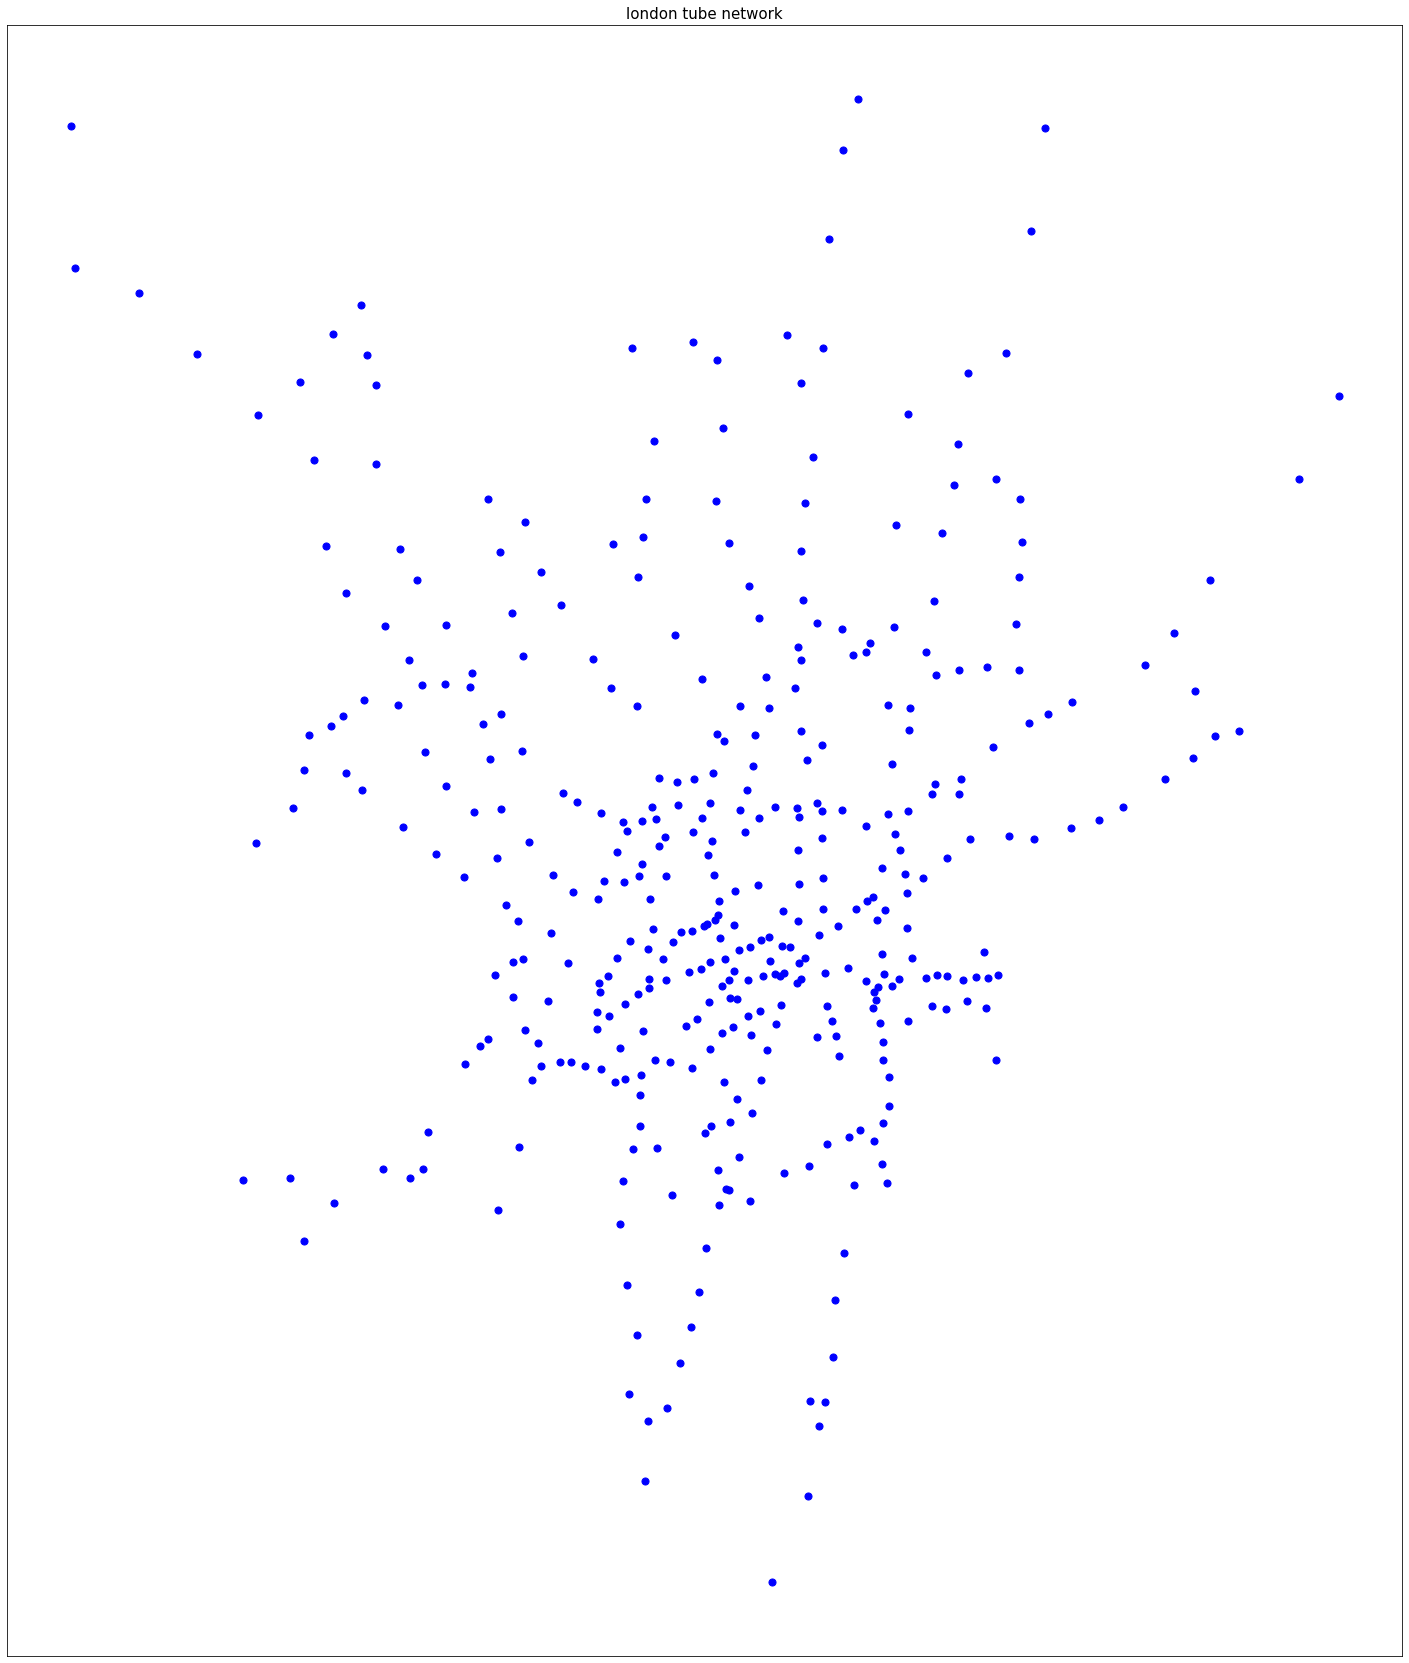

In [367]:
# checking the picture
fig, ax = plt.subplots(figsize=(25,30))

pos = nx.get_node_attributes(tube, 'coords')

nx.draw_networkx_nodes(tube, pos, node_size=50, node_color='b')

plt.title("london tube network", fontsize=15)
plt.show()

In [370]:
tubdf = pd.DataFrame(data=pos).T
tubdf

,0,1
Wembley Park,519316.559017,186389.329817
Kingsbury,519359.968860,188721.220273
Queensbury,518811.361337,189760.507377
Canons Park,518183.299683,191257.262608
Stanmore,517580.459646,192537.999481
...,...,...
Heathrow Terminal 5,504965.941220,175923.361287
Brixton,531054.149221,175421.930721
Vauxhall,530420.272131,177894.386112
Pimlico,529723.571140,178312.661081


In [371]:
tubgdf = gpd.GeoDataFrame(tubdf, geometry=gpd.points_from_xy(tubdf[0], tubdf[1]), crs='epsg:4326')

In [373]:
tubgdf.reset_index(inplace=True)
tubgdf

,index,0,1,geometry
0,Wembley Park,519316.559017,186389.329817,POINT (519316.559 186389.330)
1,Kingsbury,519359.968860,188721.220273,POINT (519359.969 188721.220)
2,Queensbury,518811.361337,189760.507377,POINT (518811.361 189760.507)
3,Canons Park,518183.299683,191257.262608,POINT (518183.300 191257.263)
4,Stanmore,517580.459646,192537.999481,POINT (517580.460 192537.999)
...,...,...,...,...
396,Heathrow Terminal 5,504965.941220,175923.361287,POINT (504965.941 175923.361)
397,Brixton,531054.149221,175421.930721,POINT (531054.149 175421.931)
398,Vauxhall,530420.272131,177894.386112,POINT (530420.272 177894.386)
399,Pimlico,529723.571140,178312.661081,POINT (529723.571 178312.661)


In [377]:
tubgdf.plot(figsize=(20,30), facecolor='None', edgecolor='black', aspect=1)

for index, row in cdata4.iterrows():
    x1 = [tubgdf[tubgdf['index'] == row['Orig']]['geometry'].x, tubgdf[tubgdf['index'] == row['Orig']]['geometry'].x]
    y1 = [tubgdf[tubgdf['index'] == row['Orig']]['geometry'].y, tubgdf[tubgdf['index'] == row['Orig']]['geometry'].y]
    plt.plot(x1, y1, linewidth = row['flows']/max(cdata4['flows'])*10, color='Blue')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fb2d21fd700> (for post_execute):


KeyboardInterrupt: 